# Imports

In [2]:
# General 
import os, glob
import numpy as np
import pandas as pd
from sklearn import preprocessing

# File and Image Processing
import netCDF4 as nc
from PIL import Image
import imageio
import cv2
import math
import cmath

# Torch
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from  torch.utils.data import Dataset

# Logging
import time
from tabulate import tabulate
from tqdm.auto import tqdm

# Showing
import matplotlib.pyplot as plt
import seaborn as sns

# Implemented by me
from files.eval import Evaluation

# Not sure
import pickle

In [3]:
# Global variables

nc_dir = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Dataset/'
nc_online_dir = r'\\envdfs.leeds.ac.uk\a321\datasets\ERA-interim'

data_dir = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Data_float32/'
data_filtered = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Data_filtered/'

img_dir = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Dataset_images/'
var_dir = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/variables/'
model_dir = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/models/'

mm_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# NetCDF

Load NetCDF files and create dataframe

In [4]:
# Functions

def normalize (layer, f_min = None, f_max = None):
    if f_min == None or f_max == None : f_min, f_max = layer.min(), layer.max()
    return (layer - f_min) / (f_max - f_min)

def convertToGrayscale(image):
    return (image[0] +  image[1] +  image[2]) / 3

def saveImage(data, filename, negative = False):
    if negative: data = 1 - normalize(data)
    else: data = normalize(data)
    data = (data * 255).round().astype(np.uint8)
    imageio.imwrite(img_dir + filename +'.png', data)

    
def resize_numpy_Image(data, negative = False, new_size = (256, 256)):
    
    # Convert to Image and Resize
    if negative: data = 1 - normalize(data)
    else: data = normalize(data)
        
    data = (data * 255).round().astype(np.uint8)
    img = Image.fromarray(data , 'L').resize(new_size) 
    data = normalize(np.array(img), 0, 255)
    
    return data
    

def numpy_resize(a, h, w):
    
    # Upsampling
    
    y, x = a.shape
    mult_y, mult_x = math.ceil(h/y), math.ceil(w/x)
    m, n = y * mult_y, x * mult_x
    
    new_a = np.broadcast_to(
        a.reshape(y, 1, x, 1), (y, mult_y, x, mult_x)
    ).reshape(m, n)
    
    # Downsampling
    
    new_a = np.array(new_a)
    y, x = new_a.shape
    
    for i in range(y - h):        
        
        i = h - i*round(h / (y - h))
        if i == h: new_a[i-1, :] = (new_a[i-1, :] + new_a[i, :]) / 2
        elif i == 0: new_a[i+1, :] = (new_a[i+1, :] + new_a[i, :]) / 2
        else: 
            new_a[i-1, :] = (new_a[i-1, :] + new_a[i, :]) / 2
            new_a[i+1, :] = (new_a[i+1, :] + new_a[i, :]) / 2
        
        new_a = np.delete(new_a, i, 0)
    
    for i in range(x - w):        
        
        i = w - i*round(w / (x - w))
        if i == h: new_a[:, i-1] = (new_a[:, i-1] + new_a[:, i]) / 2
        elif i == 0: new_a[:, i+1] = (new_a[:, i+1] + new_a[:, i]) / 2
        else: 
            new_a[:, i-1] = (new_a[:, i-1] + new_a[:, i]) / 2
            new_a[:, i+1] = (new_a[:, i+1] + new_a[:, i]) / 2
            
        new_a = np.delete(new_a, i, 1)
    
    return new_a

def openVariable(f_dir, fn):
    with open(f_dir + fn, 'rb') as f: 
        return pickle.load(f)
        
def saveVariable(data, f_dir, fn):
    with open(f_dir + fn, 'wb') as f:
        pickle.dump(data, f)

Get Elevation

In [5]:
def getElevation(filedir, filename, latbounds, lonbounds, save_filtered = False):

    # Open FILE
    cdf = nc.Dataset(filedir + '\\' + filename)    

    lats = cdf.variables['latitude'][:]
    lons = cdf.variables['longitude'][:]

    # Latitude indexes (Low and Upper)
    lat_li = np.argmin( np.abs( lats - latbounds[0] ) )
    lat_ui = np.argmin( np.abs( lats - latbounds[1] ) ) 
    # Longitude indexes (Low and Upper)
    lon_li = np.argmin( np.abs( lons - lonbounds[0] ) )
    lon_ui = np.argmin( np.abs( lons - lonbounds[1] ) ) 

    # Elevation (elevation, latitude, longitude) 
    elevation = cdf.variables['elevation'][lat_li:lat_ui , lon_li:lon_ui ].data
    cdf.close()

    # Elevation processing
    elevation = np.flip(elevation, axis = 0) # Flip by latitude
    if type(elevation[0,0]) is not np.float32: elevation = np.float32(elevation)
    
    # Save files
    if save_filtered:
        if not os.path.isfile(data_filtered + 'E_' + save_filtered):
            with open(data_filtered + 'E_' + save_filtered, 'wb') as f:
                pickle.dump(elevation, f)
    
    return elevation

Get Cloud Temperature

In [6]:
def getCloudTemperature(filedir, filename, latbounds, lonbounds, min_temperature, save_filtered = False):

    # Open FILE
    cdf = nc.Dataset(filedir + filename)    

    lats = cdf.variables['lat'][:]
    lons = cdf.variables['lon'][:]
    
    # Latitude indexes (Low and Upper)
    lat_li = np.argmin( np.abs( lats - latbounds[0] ) )
    lat_ui = np.argmin( np.abs( lats - latbounds[1] ) ) 
    # Longitude indexes (Low and Upper)
    lon_li = np.argmin( np.abs( lons - lonbounds[0] ) )
    lon_ui = np.argmin( np.abs( lons - lonbounds[1] ) )  

    # BT (bt, latitude, longitude) 
    bt = cdf.variables['BT'][lat_li:lat_ui , lon_li:lon_ui ] 
    cdf.close()
    
    # Skip if BT outside interval
    if bt.data.min() < -100 or bt.data.max() > 100:
        return None
    
    # BT processing    
    # Remove low clouds and flip
    bt[bt > min_temperature] = 0
    bt = np.flip(bt.data, axis = 0) # Flip by latitude
    bt = bt * -1
    if type(bt[0,0]) is not np.float32: bt = np.float32(bt)
    
    # Save files
    if save_filtered:
        if not os.path.isfile(data_filtered + 'BT_' + save_filtered):
            with open(data_filtered + 'BT_' + save_filtered, 'wb') as f:
                pickle.dump(bt, f)
    
    return bt

Get Wind Speed

In [7]:
def getWindSpeed(filedir, latbounds, lonbounds, pressure_level, save_filtered = False):
    
    # Open FILE
    cdf = nc.Dataset(filedir)    

    lats = cdf.variables['latitude'][:]
    lons = cdf.variables['longitude'][:]

    # Inverse data distribution than cloud temperature
    # Latitude indexes (Low and Upper)
    lat_li = np.argmin( np.abs( lats - latbounds[1] ) )
    lat_ui = np.argmin( np.abs( lats - latbounds[0] ) ) 
    # Longitude indexes (Low and Upper)
    lon_ui = np.argmin( np.abs( lons - lonbounds[1] ) )
    lon_li = np.argmin( np.abs( lons - int(360 - abs(lonbounds[0])) ) )
    
    # U (t, p, latitude, longitude) - U velocity - eastward_wind (m s**-1)
    u_li = cdf.variables['U'][0][pressure_level][lat_li:lat_ui, :lon_ui].data
    u_up = cdf.variables['U'][0][pressure_level][lat_li:lat_ui, lon_li:].data

    # V (t, p, latitude, longitude) - V velocity - northward_wind (m s**-1)
    v_li = cdf.variables['V'][0][pressure_level][lat_li:lat_ui, :lon_ui].data
    v_up = cdf.variables['V'][0][pressure_level][lat_li:lat_ui, lon_li:].data
    
    cdf.close()
    
    # U and V processing 
    u = np.concatenate((u_up, u_li), axis=1)
    u = np.flip(u, axis = 0) # Flip by latitude
    if type(u[0,0]) is not np.float32: u = np.float32(u)
    
    v = np.concatenate((v_up, v_li), axis=1)
    v = np.flip(v, axis = 0) # Flip by latitude
    if type(v[0,0]) is not np.float32: v = np.float32(v)
    
    # Save files
    if save_filtered:
        if not os.path.isfile(data_filtered + 'U_' + save_filtered):
            with open(data_filtered + 'U_' + save_filtered, 'wb') as f:
                pickle.dump(u, f)
        if not os.path.isfile(data_filtered + 'V_' + save_filtered):
            with open(data_filtered + 'V_' + save_filtered, 'wb') as f:
                pickle.dump(v, f)

    return u, v

def getWindFileDirectory(root, date, time):    
    file = root + '\\' + date[0:4] + '\\ap\\' + 'ggap' + date
    
    time = int(time[0:2])
    if time < 6: return file + '0000.nc'
    elif time < 12: return file + '0600.nc'
    elif time < 18: return file + '1200.nc'
    else: return file + '1800.nc'
    

Get Temperature and Wind data, and combine them with Elevation data into one file

In [8]:
# Variables
nc_errors = []
filenames = [filename for filename in os.listdir(nc_dir) if filename.startswith("SEVIRI")]

# Location for West Africa
latbounds = [ 0, 30 ] # From 0 to 30N
lonbounds = [ -20, 20 ] # From 20W to 20E

for i in tqdm(range(len(filenames))):
    fn = filenames[i]
    
    nc_id = os.path.splitext(os.path.basename(fn))[0]
    date = nc_id[nc_id.index('_', 10, 15)+1:nc_id.index('_', 25)]
    day_time = date[8:]
    date = date[:8]
    nc_date = date + '-' + day_time
    
    # Skip if already converted to data
    if os.path.isfile(data_dir + nc_date):
        continue
    
    # Get Cloud
    bt = getCloudTemperature(nc_dir, fn, latbounds, lonbounds, -40)
    # Skip if BT outside interval
    if bt is None:
        nc_errors.append(fn)
        continue
    bt = resize_numpy_Image(bt)
    
    # Get Elevation
    elevation = getElevation(nc_dir, 'elevation.0.0625-deg.nc', latbounds, lonbounds)
    elevation = resize_numpy_Image(elevation)
    
    # Get Wind
    wind_fd = getWindFileDirectory(nc_online_dir, date, day_time)
    u, v = getWindSpeed(wind_fd, latbounds, lonbounds, 11)
    u = numpy_resize(u, 256, 256)
    u = mm_scaler.fit_transform(u)
    v = numpy_resize(v, 256, 256)
    v = mm_scaler.fit_transform(v)
    

    # Merge data
    data = np.stack((bt, elevation, u, v), axis = 2)
    
    # Save file
    with open(data_dir + nc_date, 'wb') as f:
        pickle.dump(data, f)

print('Errors: ' + str(len(nc_errors)))
# print("\n".join(nc_errors))


Errors: 63


In [9]:
# Create data frame
nc_ids = []
nc_dates = []
nc_hours = []
nc_minutes = []
filenames = glob.glob(data_dir + '*')

for i in tqdm(range(len(filenames))):
    fn = filenames[i]
    
    nc_id = os.path.splitext(os.path.basename(fn))[0]
    nc_ids.append(nc_id)
    
    nc_dates.append(nc_id[:8])
    nc_hours.append(int(nc_id[9:11]))
    nc_minutes.append(int(nc_id[11:13]))

data = {
    'nc_id': nc_ids,
    'date': nc_dates,
    'hour': nc_hours,
    'minute': nc_minutes,
    'path': [data_dir + nc_id for nc_id in nc_ids]
}

data_df = pd.DataFrame(data, columns=['nc_id', 'date', 'hour', 'minute','path'])
data_df

,nc_id,date,hour,minute,path
0,20170401-0000,20170401,0,0,C:/Users/marcv/OneDrive/Documentos/Python Scri...
1,20170401-0030,20170401,0,30,C:/Users/marcv/OneDrive/Documentos/Python Scri...
2,20170401-0100,20170401,1,0,C:/Users/marcv/OneDrive/Documentos/Python Scri...
3,20170401-0130,20170401,1,30,C:/Users/marcv/OneDrive/Documentos/Python Scri...
4,20170401-0200,20170401,2,0,C:/Users/marcv/OneDrive/Documentos/Python Scri...
...,...,...,...,...,...
17500,20180930-2130,20180930,21,30,C:/Users/marcv/OneDrive/Documentos/Python Scri...
17501,20180930-2200,20180930,22,0,C:/Users/marcv/OneDrive/Documentos/Python Scri...
17502,20180930-2230,20180930,22,30,C:/Users/marcv/OneDrive/Documentos/Python Scri...
17503,20180930-2300,20180930,23,0,C:/Users/marcv/OneDrive/Documentos/Python Scri...


In [10]:
# Create dataset class

class NetCDFNet(Dataset):
    """ ImageNet10 dataset. """

    def __init__(self, df, transform=None, input_frames = 2, output_frames = 1, input_channels = 1):
        """
        Args:
            image_dir (string): Directory with all the images
            df (DataFrame object): Dataframe containing the images, paths and classes
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = df
        self.transform = transform
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.input_channels = input_channels

    def __len__(self):
        return len(self.df) - self.input_frames - self.output_frames + 1
    
    def __getitem__(self, index):
        """ Returns one data pair (date and image). """

        date = self.df['date'][index]
        hour = self.df['hour'][index]
        minute = self.df['minute'][index]
        
        x = [self.openData(self.df['path'][index + i]) for i in range(self.input_frames)]
        # First target is second input
        y = [self.openData(self.df['path'][index + i + 1]) for i in range(self.output_frames + self.input_frames - 1)] 
        
        for i in range(self.input_frames):
            f_min, f_max = x[i][:,:,2].min(), x[i][:,:,2].max()
            x[i][:,:,2] = (x[i][:,:,2] - f_min) / (f_max - f_min)
            f_min, f_max = x[i][:,:,3].min(), x[i][:,:,3].max()
            x[i][:,:,3] = (x[i][:,:,3] - f_min) / (f_max - f_min)
            
        
        if self.transform is not None:
            x = [self.transform(image) for image in x]
            y = [self.transform(image) for image in y]
        
        x = [dat[:self.input_channels,:,:] for dat in x]
        y = [dat[:1,:,:] for dat in y]
        
        x = np.concatenate(x)
        y = np.concatenate(y)

        return x, y, [date, hour, minute]
    
    def openData(self, path):
        with open(path, 'rb') as f: 
            return pickle.load(f)
    

Transform

In [11]:
data_transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(),
    ])

data_transform_valid = transforms.Compose([
        transforms.ToTensor(),
    ])


Dataloader from dataframe generator

In [12]:
def generateDataIndexesSplits(data, split, reset_length):
    train_indexes, valid_indexes = [], []
    data = data_df.index.tolist()
    size = len(data)
    train_size_split = int(split*reset_length)
    valid_size_split = int((1-split)*reset_length)
    
    for i in range(round(size/reset_length)):
        
        train_indexes.extend(data[:train_size_split])
        valid_indexes.extend(data[train_size_split:train_size_split+valid_size_split])
        
        # Remove used data from original df
        data = data[train_size_split+valid_size_split:]
    
    return train_indexes, valid_indexes

def generateDataloaderSplits(data, split, reset_length, transforms, in_frames, out_frames, channels):
    train_loaders, valid_loaders = [], []
    size = len(data)
    train_size_split = int(split*reset_length)
    valid_size_split = int((1-split)*reset_length)
    
    for i in range(round(size/reset_length)):
        
        # Create Splits and Generate datasets
        ins_dataset_train = NetCDFNet(
            df=data[:train_size_split].reset_index(drop=True),
            transform=transforms[0],
            input_frames = in_frames, output_frames = out_frames, input_channels = in_channels,
        )

        ins_dataset_valid = NetCDFNet(
            df=data[train_size_split:train_size_split+valid_size_split].reset_index(drop=True),
            transform=transforms[1],
            input_frames = in_frames, output_frames = out_frames, input_channels = in_channels,
        )
        
        # Generate loaders and append
        train_loader = torch.utils.data.DataLoader(
            ins_dataset_train, batch_size = 8, shuffle = True,
            num_workers = 0, pin_memory = True
        )

        valid_loader = torch.utils.data.DataLoader(
            ins_dataset_valid, batch_size = 8, shuffle = False, 
            num_workers = 0, pin_memory = True
        )
        train_loaders.append(train_loader)
        valid_loaders.append(valid_loader)
        
        # Remove used data from original df
        data = data[train_size_split+valid_size_split:]
    
    return train_loaders, valid_loaders

Data Loaders

In [13]:
train_split = 0.75
dates_length = 2*24*7*4 # 2im/h * 24h * 7d * 4w -> batches of 4 weeks

in_frames = 2
out_frames = 10
in_channels = 4

train_indexes, valid_indexes = generateDataIndexesSplits(data_df, train_split, dates_length)

train_loaders, valid_loaders = generateDataloaderSplits(data_df, train_split, dates_length, 
                                       [data_transform_train, data_transform_valid], 
                                       in_frames, out_frames, in_channels)


#train_loaders = openVariable(var_dir, 'train_loaders_#4_2to10')    
#valid_loaders = openVariable(var_dir, 'valid_loaders_#4_2to10')
        
# saveVariable(train_loaders, var_dir, 'train_loaders_#4_3to10')
# saveVariable(valid_loaders, var_dir, 'valid_loaders_#4_3to10')

You can optionally seed the Random Number Generator across all devices for testing purposes.

In [14]:
torch.manual_seed(1)

We can now create device where we refer to GPU or CPU.

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Model



In [17]:
from files.convlstm import ConvLSTMCell as ConvLSTM

class NN_LSTM(nn.Module):
    def __init__(self, num_channels):
        super(NN_LSTM, self).__init__()
        
        self.num_channels = num_channels   
        
        channels = [self.num_channels, 16, 24, 32, 64,  128, 64,  64, 32, 32, 24, 10]
#         channels = [self.num_channels, 24, 48, 64, 128, 256, 128, 128, 64, 64, 48, 16]
        
        bn_param = dict(momentum=0.9997)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv1 = nn.Conv2d(channels[0], channels[1], kernel_size = 5, stride = 1, padding = 2, bias = True)
        self.conv1_bn = nn.BatchNorm2d(channels[1], **bn_param)
        
        self.conv2 = ConvLSTM(input_dim=channels[1], hidden_dim=channels[2], kernel_size=(3, 3), bias=True)
        self.conv2_bn = nn.BatchNorm2d(channels[2], **bn_param)
        
        self.conv3 = ConvLSTM(input_dim=channels[2], hidden_dim=channels[3], kernel_size=(3, 3), bias=True)
        self.conv3_bn = nn.BatchNorm2d(channels[3], **bn_param)

        self.rnn1 = ConvLSTM(input_dim=channels[3], hidden_dim=channels[4], kernel_size=(5, 5), bias=True)
        self.rnn1_bn = nn.BatchNorm2d(channels[4], **bn_param) 
        
        self.rnn2 = ConvLSTM(input_dim=channels[4], hidden_dim=channels[5], kernel_size=(5, 5), bias=True)
        self.rnn2_bn = nn.BatchNorm2d(channels[5], **bn_param)
        
        self.rnn3 = ConvLSTM(input_dim=channels[5], hidden_dim=channels[5], kernel_size=(5, 5), bias=True)
        self.rnn3_bn = nn.BatchNorm2d(channels[5], **bn_param)
        
        self.deconv1 = nn.ConvTranspose2d(channels[5], channels[6], kernel_size = 3, stride = 2, padding = 1, 
                                          output_padding = 1, bias = False)
        self.deconv1_bn = nn.BatchNorm2d(channels[6], **bn_param) 
        
        self.rnn4 = ConvLSTM(input_dim=channels[6], hidden_dim=channels[7], kernel_size=(5, 5), bias=True)
        self.rnn4_bn = nn.BatchNorm2d(channels[7], **bn_param)
        
        self.deconv2 = nn.ConvTranspose2d(channels[7], channels[8], kernel_size= 3 , stride = 2, padding = 1,
                                          output_padding = 1, bias = False)
        self.deconv2_bn = nn.BatchNorm2d(channels[8], **bn_param)
        
        self.rnn5 = ConvLSTM(input_dim=channels[8], hidden_dim=channels[9], kernel_size=(5, 5), bias=True)
        self.rnn5_bn = nn.BatchNorm2d(channels[9], **bn_param)
        
        self.deconv3 = nn.ConvTranspose2d(int(channels[9]*2), channels[10], kernel_size = 3, stride = 2, padding = 1, 
                                          output_padding = 1, bias = True)
#         self.deconv3 = nn.Upsample(scale_factor=2)
        self.deconv3_c = ConvLSTM(input_dim=channels[10], hidden_dim=channels[10], kernel_size=(3, 3), bias=True)
        self.deconv3_bn = nn.BatchNorm2d(channels[10], **bn_param)
        
        self.deconv4 = nn.Upsample(scale_factor=2)
        self.deconv4_c = ConvLSTM(input_dim=int(channels[10]*2), hidden_dim=channels[11], kernel_size=(3, 3), bias=True)
        self.deconv4_bn = nn.BatchNorm2d(channels[11], **bn_param)

        self.conv4 = nn.ConvTranspose2d(channels[11], 1, kernel_size = 1, stride = 1, padding = 0, bias = True)
        
    def forward(self, x, out_frames_training = 1, total_out_frames = 0):
        
        input = x
        
        input_length = int(input.shape[1]/self.num_channels)
        out_images = None
        
        conv2_state, conv3_state, deconv3_state, deconv4_state = None, None, None, None
        lstm1_state, lstm2_state, lstm3_state = None, None, None
        lstm4_state, lstm5_state = None, None
        
        # Regular number of predictions or set by parameter (Taking into account that there are frames along the input frames)
        for i in range(max(input_length + out_frames_training - 1, input_length + total_out_frames - 1)):             
            
            # Using Inputs
            if i < input_length:
                cur_input = input[:, i*self.num_channels:(i+1)*self.num_channels]
            # Reusing Outputs
            else:
                # Add channels to output
                if self.num_channels == 1: cur_input = out_images[:, -1:]
                else: cur_input = torch.cat((out_images[:, -1:], cur_input[:,-(self.num_channels-1):]), dim = 1) 
        
            # Conv 1
            x = self.conv1(cur_input)
            x = self.conv1_bn(x)
            x = self.relu(x)
            
            x = self.pool(x)
            
            # Conv 2
            if i < input_length: x, conv2_state = self.conv2(x, conv2_state)
            else: x, _ = self.conv2(x, conv2_state)
            x = self.conv2_bn(x)
            out_conv2 = self.relu(x)
            
            x = self.pool(out_conv2)
            
            # Conv 3
            if i < input_length: x, conv3_state = self.conv3(x, conv3_state)
            else: x, _ = self.conv3(x, conv3_state)
            x = self.conv3_bn(x)
            out_conv3 = self.relu(x)
            
            #x = self.pool(out_conv3)
        
            # RNN 1
            if i < input_length: x, lstm1_state = self.rnn1(out_conv3, lstm1_state)
            else: x, _ = self.rnn1(out_conv3, lstm1_state)
            x = self.rnn1_bn(x)
            
            x = self.pool(x)
            
            # RNN 2
            if i < input_length: x, lstm2_state = self.rnn2(x, lstm2_state)
            else: x, _ = self.rnn2(x, lstm2_state)
            x = self.rnn2_bn(x)
            
            x = self.pool(x)

            # RNN 3
            if i < input_length: x, lstm3_state = self.rnn3(x, lstm3_state)
            else: x, _ = self.rnn3(x, lstm3_state)
            out_rnn3 = self.rnn3_bn(x)
            
            # Deconv 1
            x = self.deconv1(x)
#             x = self.deconv1_bn(x)
            
            # RNN 4
            if i < input_length: x, lstm4_state = self.rnn4(x, lstm4_state)
            else: x, _ = self.rnn4(x, lstm4_state)
            x = self.rnn4_bn(x)

            # Deconv 2
            x = self.deconv2(x)
#             x = self.deconv2_bn(x)

            # RNN 5
            if i < input_length: x, lstm5_state = self.rnn5(x, lstm5_state)
            else: x, _ = self.rnn5(x, lstm5_state)
            x = self.rnn5_bn(x)
            
            # Skip Connection
            x = torch.cat([x, out_conv3], dim=1)
            
             # Deconv 3
            x = self.deconv3(x)
            if i < input_length: x, deconv3_state = self.deconv3_c(x, deconv3_state)
            else: x, _ = self.deconv3_c(x, deconv3_state)
            x = self.deconv3_bn(x)
            x = self.relu(x)

            # Skip Connection
            x = torch.cat([x, out_conv2], dim=1)
            
            # Deconv 4
            x = self.deconv4(x)
            if i < input_length: x, deconv4_state = self.deconv4_c(x, deconv4_state)
            else: x, _ = self.deconv4_c(x, deconv4_state)
            x = self.deconv4_bn(x)
            out_deconv4 = self.relu(x)

            # Conv 4
            x = self.conv4(out_deconv4)
            x = self.relu(x)
            
            if out_images is None: out_images = x
            else: out_images = torch.cat((out_images, x), dim = 1)
        
        return out_images

    def getAttribute(self, name):
        return eval('self.'+ name)


In [18]:
# Create Convolution Network

class ConvNet(nn.Module):
    
    def __init__(self, input_frames, num_channels):
        super(ConvNet, self).__init__()    #nx256x256
        
        self.num_channels = num_channels
        self.input_frames = input_frames
        bn_param = dict(momentum=0.9997)
        
        channels = [input_frames * num_channels, 32, 64, 128, 258, 368, 368, 368, 258, 128, 64, 32]
#         channels = [input_frames * num_channels, 64, 128, 256, 368, 512, 512, 512, 368, 256, 128, 64]
        
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv1 = nn.Conv2d(channels[0], channels[1], kernel_size = 5, stride = 1, padding = 2, bias = True)
        self.conv1_bn = nn.BatchNorm2d(channels[1], **bn_param)

        self.conv2 = nn.Conv2d(channels[1], channels[2], kernel_size = 5, stride = 1, padding = 2, bias = True)
        self.conv2_bn = nn.BatchNorm2d(channels[2], **bn_param)

        self.conv3 = nn.Conv2d(channels[2], channels[3], kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.conv3_bn = nn.BatchNorm2d(channels[3], **bn_param)
        
        self.conv4 = nn.Conv2d(channels[3], channels[4], kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.conv4_bn = nn.BatchNorm2d(channels[4], **bn_param)
        
        self.conv5 = nn.Conv2d(channels[4], channels[5], kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.conv5_bn = nn.BatchNorm2d(channels[5], **bn_param)

        self.bottleneck = nn.Conv2d(channels[6], channels[6], kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.bottleneck_bn = nn.BatchNorm2d(channels[6], **bn_param)
        
        self.deconv1 = nn.Conv2d(channels[6] + channels[5], channels[7], kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.deconv1_bn = nn.BatchNorm2d(channels[7], **bn_param)
        
        self.deconv2 = nn.Conv2d(channels[7] + channels[4], channels[8], kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.deconv2_bn = nn.BatchNorm2d(channels[8], **bn_param)

        self.deconv3 = nn.Conv2d(channels[8] + channels[3], channels[9], kernel_size = 3, stride = 1, padding = 1, bias = True)
        self.deconv3_bn = nn.BatchNorm2d(channels[9], **bn_param)

        self.deconv4 = nn.Conv2d(channels[9] + channels[2], channels[10], kernel_size= 5 , stride = 1, padding = 2, bias = True)
        self.deconv4_bn = nn.BatchNorm2d(channels[10], **bn_param)

        self.deconv5 = nn.Conv2d(channels[10] + channels[1], channels[11], kernel_size = 5, stride = 1, padding = 2, bias = True)
        self.deconv5_bn = nn.BatchNorm2d(channels[11], **bn_param)

        self.convF = nn.Conv2d(channels[11], 1, kernel_size = 5, stride = 1, padding = 2)
        
    def forward(self, input, total_out_frames = 0, output_level = 1):
        
        x = input
    
        x = self.conv1(x)
        x = self.conv1_bn(x)
        conv1 = self.relu(x)

        x = self.pool(conv1)

        x = self.conv2(x)
        x = self.conv2_bn(x)
        conv2 = self.relu(x)

        x = self.pool(conv2)

        x = self.conv3(x)
        x = self.conv3_bn(x)
        conv3 = self.relu(x)

        x = self.pool(conv3)
        
        x = self.conv4(x)
        x = self.conv4_bn(x)
        conv4 = self.relu(x)

        x = self.pool(conv4)
        
        x = self.conv5(x)
        x = self.conv5_bn(x)
        conv5 = self.relu(x)

        x = self.pool(conv5)

        x = self.bottleneck(x)
        x = self.bottleneck_bn(x)
        x = self.relu(x)
        
#         x = nn.functional.interpolate(x, scale_factor = 2, mode = 'biliniar', align_corners = False)
        x = nn.functional.interpolate(x, scale_factor = 2, mode = 'nearest')

        x = torch.cat([x, conv5], dim=1)
        x = self.deconv1(x)
        x = self.deconv1_bn(x)
        x = self.relu(x)
        
        x = nn.functional.interpolate(x, scale_factor = 2, mode = 'nearest')

        x = torch.cat([x, conv4], dim=1)
        x = self.deconv2(x)
        x = self.deconv2_bn(x)
        x = self.relu(x)

        x = nn.functional.interpolate(x, scale_factor = 2, mode = 'nearest')

        x = torch.cat([x, conv3], dim=1)
        x = self.deconv3(x)
        x = self.deconv3_bn(x)
        x = self.relu(x)

        x = nn.functional.interpolate(x, scale_factor = 2, mode = 'nearest')

        x = torch.cat([x, conv2], dim=1)
        x = self.deconv4(x)
        x = self.deconv4_bn(x)
        x = self.relu(x)

        x = nn.functional.interpolate(x, scale_factor = 2, mode = 'nearest')

        x = torch.cat([x, conv1], dim=1)
        x = self.deconv5(x)
        x = self.deconv5_bn(x)
        x = self.relu(x)

        x = self.convF(x)
        x = self.relu(x)
        
        if output_level < total_out_frames:
            # Add channels to output
            if self.num_channels == 1: cur_out = x
            else: cur_out = torch.cat((x, input[:,-(self.num_channels-1):]), dim = 1) 
                
            next_input = torch.cat((input[:,  -self.num_channels:], cur_out), dim = 1)
            t = self.forward(next_input, total_out_frames = total_out_frames, output_level = (output_level + 1))
            x = torch.cat([x, t], dim = 1)
              
        return x
    
    def getAttribute(self, name):
        return eval('self.'+ name)

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def update(self, val, n=1):
        if self.val is None:
            self.val = val
            self.sum = val * n
            self.count = n
            self.avg = self.sum / self.count
        else:
            self.val = val
            self.sum += val * n
            self.count += n
            self.avg = self.sum / self.count

In [20]:
def train(train_loaders, model, optimizer, scheduler, criterion, eval_params, num_epochs):
    
    # Local logging variables
    batch_time = AverageMeter()
    data_time = AverageMeter()
    running_loss = 0.0
    
    # Global logging variables
    best_model_params = None
    loss_log = []
    loss_val_log = []
    lr_log = []
    logging_info = [0, 0, 0]
    
    # Compute total length of all loaders
    total_length = sum(len(tl) for tl in train_loaders)
    
    # Run for all epochs
    for epoch in tqdm(range(num_epochs)):
        
        # Log validation loss before training
        if len(loss_val_log) == 0:
#             loss_val, _ = validate(valid_loaders, model, criterion, eval_params, all_outputs = False)
            loss_val = 0.0260820058720644
            loss_val_log.append(loss_val)
            scheduler.step(loss_val)

        # Switch to train mode
        model.train()    
            
        # Log data access time
        start = time.time()
        i = 0
        
        with tqdm(total=total_length) as pbar:
        
            for _, train_loader in enumerate(train_loaders):

                for _, (input, target, _) in enumerate(train_loader):

                    # Log access data time
                    data_time.update(time.time() - start)
                    start = time.time()

                    # compute output
                    input_var = torch.autograd.Variable(input).to(device)
                    output = model(input_var)

                    # CNN
#                     target_var = torch.autograd.Variable(
#                         target[:, (model.getAttribute('input_frames')-1):(output.shape[1]+1)]
#                     ).to(device)
                    # ConvLSTM
                    target_var = torch.autograd.Variable(target[:, :output.shape[1]]).to(device)

                    # measure accuracy and record loss
                    loss = criterion(output, target_var)
                    running_loss += loss.item()

                    # compute gradient and do SGD step
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                    # measure elapsed time
                    batch_time.update(time.time() - start)
            
                    # Show Log
                    if (i + 1) % train_log_freq == 0 or (i + 1) == total_length:
                        loss_val = running_loss / train_log_freq
                        print(('Epoch: [{0}][{1}/{2}]\t'
                               'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                               'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                               'Loss {loss:.4f}\t'.format(
                                   epoch + 1, i + 1, total_length,
                                   batch_time=batch_time, data_time=data_time, loss=loss_val)))
                        loss_log.append(loss_val)
                        lr_log.append(optimizer.param_groups[0]['lr'])
                        running_loss = 0.0
                        batch_time.reset()
                        data_time.reset()

                    # Evaluate model
                    if (i + 1) % train_validate_freq == 0 or (i + 1) == total_length:
                        loss_val, _ = validate(valid_loaders, model, criterion, eval_params, all_outputs = False)
                        loss_val_log.append(loss_val)
                        scheduler.step(loss_val) 
                        model.train()

                        if min(loss_val_log) == loss_val:
                            best_model_params = model.state_dict()
                            logging_info = [epoch + 1, i + 1, loss_val]

                    # Update progress bar and timer
                    start = time.time()
                    i = i + 1
                    pbar.update(i - pbar.n)
    
    print(f"-------------------------------- \n"
          f"  SUMMARY of BEST RESULT \n"
          f"  At epoch / it [{logging_info[0]}/{num_epochs}][{logging_info[1]}/{total_length}] \n"
          f"  Validation loss: {logging_info[2]:.3f} \n"
          f"--------------------------------")
    
    return best_model_params, [loss_log, loss_val_log, lr_log]

def criterionLoss_mean2sum(loss, criterion, shape):
    if criterion.reduction == 'mean':
        return loss * (shape[0] * shape[1] * shape[2] * shape[3])
    else:
        return loss

In [21]:
def validate(valid_loaders, model, criterion, eval_params, all_outputs = False):
    
    # Switch to eval mode
    print('Starting validation... ' + time.ctime())
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.track_running_stats = False
    
    with torch.no_grad():
        
        running_loss = 0.0
        evaluators = [Evaluation(eval_params[0], eval_params[1], eval_params[2], eval_params[3]) for i in range(out_frames)]        
     
        # Compute total length of all loaders
        total_length = sum(len(tl) for tl in valid_loaders)
        i = 0
    
        # Show progress bar
        if all_outputs: loader = globals()['tqdm'](valid_loaders)
        else: loader = valid_loaders
        
        # Log data access time
        start = time.time()
        
        for _, valid_loader in enumerate(loader):
        
            for i, (input, target, _) in enumerate(valid_loader):
                
                num_channels = model.getAttribute('num_channels')
                in_frames = 2#int( input.shape[1] / num_channels ) 
                
                if not all_outputs:

                    # compute output
                    input_var = torch.autograd.Variable(input).to(device)
                    output = model(input_var)

                    # Compute Loss                
                    target_var = torch.autograd.Variable(target[:, (in_frames-1):(output.shape[1]+1)]).to(device) # CNN               
#                     target_var = torch.autograd.Variable(target[:, :output.shape[1]]).to(device) # ConvLSTM     
                    loss = criterion(output, target_var)
                    running_loss += loss.item()

                    # Compute Accuracy
                    pred = output.data.cpu().numpy() # CNN
#                     pred = output[:, (in_frames-1):in_frames].data.cpu().numpy() #ConvLSTM
                    tar = target[:, (in_frames-1):in_frames].cpu().numpy()

                    evaluators[0](pred, tar)


                else:
                    # compute output
                    input_var = torch.autograd.Variable(input).to(device)
                    output = model(input_var, total_out_frames = out_frames)

                    # Compute loss (Only actual outputs)
                    target_var = torch.autograd.Variable(target[:, (in_frames-1):]).to(device)
#                     output = output[:, (in_frames-1):] # ConvLSTM
#                     loss = criterion(output, target_var)
#                     running_loss += loss.item()

                    preds = output.data.cpu().numpy()
                    last_input = target[:, :1].cpu().numpy()
                    target = target[:, (in_frames-1):].cpu().numpy()
                    
                    # Compute Accuracy
                    for output_level in range(out_frames):     
                        # Compute loss
                        loss = criterion(output[:, output_level:(output_level+1)], target_var[:, output_level:(output_level+1)])
                        evaluators[output_level].addLoss(loss.item())
                        
                        # Regular methods
                        evaluators[output_level](
                            preds[:, output_level:(output_level+1)], 
                            target[:, output_level:(output_level+1)]
                        )
                        # Cloud tracking
                        if output_level is 0:
                            evaluators[output_level].compute_cloud_movement_batch(
                                preds[:, :1],
                                last_input # Last temperature from input data
                            )
                        else: 
                            evaluators[output_level].compute_cloud_movement_batch(
                                preds[:, output_level:(output_level+1)],  # Current output
                                preds[:, (output_level-1):(output_level)] # Previous output
                            )
                
                    
        # Print results            
        losses = [ev.Loss() for ev in evaluators]
        psnrs = [ev.PSNR() for ev in evaluators]
        ssim = [ev.SSIM() for ev in evaluators]
#         fss = [ev.FSS() for ev in evaluators]
        cloud_sizes = [ev.CloudSize() for ev in evaluators]
        cloud_sizes_tar = [ev.CloudSizeTarget() for ev in evaluators]
        moves = [ev.MovingDistance(2) for ev in evaluators]
        
        loss_val = running_loss / total_length
        print('Evaluation loss: ' + str(loss_val) + '       (' + str((time.time() - start)) + 's)')
        if all_outputs:
            table = [list(range(1, len(evaluators) + 1)), losses, psnrs, ssim, cloud_sizes, cloud_sizes_tar]
            print(tabulate(table))
            table = [list(range(1, len(evaluators) + 1)), 
                     [move[0][0] for move in moves], [move[0][1] for move in moves], 
                     [move[1][0] for move in moves], [move[1][1] for move in moves], 
                     [move[2][0] for move in moves], [move[2][1] for move in moves],
                     [move[3][0] for move in moves], [move[3][1] for move in moves]]
            print(tabulate(table))
        else:
            table = [list(range(1, 2)), psnrs[0:1], ssim[0:1], fss[0:1], 
                     cloud_sizes[0:1], cloud_sizes_tar[0:1]]
                
        return loss_val, evaluators

In [22]:
def filterByTime(data, datetime, hour_1, hour_2):
    tmp = []
    for i in range(len(datetime[0])):
        if datetime[1][i] == hour_1 or (datetime[1][i] == hour_2 and datetime[2][i] == 0):
            tmp.append(i)
    tmp = torch.tensor(tmp)

    if len(tmp) > 0:
        return torch.index_select(data, 0, tmp)
    else:
        return None

def evaluateCloudSizeByTime(valid_loaders, model, elevation):
    
    # Switch to eval mode
    print('Starting Storm Size validation... ' + time.ctime())
    model.eval()
    for m in model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.track_running_stats = False
    
    with torch.no_grad():
        
        eval_params = [1, [], 1, 0.1]
        
        evaluators = [[Evaluation(eval_params[0], eval_params[1], eval_params[2], eval_params[3]) for i in range(out_frames)] for i in range(4)]
     
        # Compute total length of all loaders
        total_length = sum(len(tl) for tl in valid_loaders)
        i = 0
        
        # Log data access time
        start = time.time()
        
        for _, valid_loader in enumerate(tqdm(valid_loaders)):
        
            for i, (input, target, datetime) in enumerate(valid_loader):
                
                in_data = [filterByTime(input, datetime, 0, 1), filterByTime(input, datetime, 6, 7), filterByTime(input, datetime, 12, 13), filterByTime(input, datetime, 18, 19)]
                tar_data = [filterByTime(target, datetime, 0, 1), filterByTime(target, datetime, 6, 7), filterByTime(target, datetime, 12, 13), filterByTime(target, datetime, 18, 19)]
                
                num_channels = model.getAttribute('num_channels')
                in_frames = 2 #int( input.shape[1] / num_channels ) 

                for t in range(len(in_data)):
                    in_tmp = in_data[t]
                    tar_tmp = tar_data[t]
                    
                    if in_tmp is None or tar_tmp is None: 
                        continue
                        
                    # compute output
                    input_var = torch.autograd.Variable(in_tmp).to(device)
                    output = model(input_var, total_out_frames = out_frames)

#                     output = output[:, (in_frames-1):] # ConvLSTM
                    preds = output.data.cpu().numpy()
                    preds_ocean = preds.copy()
                    preds_land = preds.copy()
                    for b in range(len(preds)):
                        for c in range(len(preds[b])):
                            preds_ocean[b][c][elevation > 0.02] = 0
                            preds_land[b][c][elevation < 0.02] = 0
        
                    # Compute Accuracy
                    for output_level in range(out_frames):     
                        # Regular methods
                        evaluators[t][output_level](
                            preds_ocean[:, output_level:(output_level+1)], 
                            preds_land[:, output_level:(output_level+1)]
                        )
                
                    
        # Print results                    
        cloud_sizes_0_ocean = [ev.CloudSize() for ev in evaluators[0]]
        cloud_sizes_0_land = [ev.CloudSizeTarget() for ev in evaluators[0]]
        cloud_sizes_6_ocean = [ev.CloudSize() for ev in evaluators[1]]
        cloud_sizes_6_land = [ev.CloudSizeTarget() for ev in evaluators[1]]
        cloud_sizes_12_ocean = [ev.CloudSize() for ev in evaluators[2]]
        cloud_sizes_12_land = [ev.CloudSizeTarget() for ev in evaluators[2]]
        cloud_sizes_18_ocean = [ev.CloudSize() for ev in evaluators[3]]
        cloud_sizes_18_land = [ev.CloudSizeTarget() for ev in evaluators[3]]
    
        table = [list(range(1, len(evaluators[0]) + 1)), 
                 cloud_sizes_0_ocean, cloud_sizes_0_land,
                 cloud_sizes_6_ocean, cloud_sizes_6_land, 
                 cloud_sizes_12_ocean, cloud_sizes_12_land, 
                 cloud_sizes_18_ocean, cloud_sizes_18_land]
        print(tabulate(table))
                
        return evaluators

In [23]:
def loadCheckpoint(model, optimizer, fd, fn):
    checkpoint = torch.load(fd + fn + '.ckpt')
    
    epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['model'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    scheduler = checkpoint['scheduler']
    loss_logger = checkpoint['loss_logger']
    
    print("=> loaded checkpoint '{}' (epoch {})".format(fn, checkpoint['epoch']))
    return epoch, model, optimizer, scheduler, loss_logger

def loadModel(model, fd, fn):
    model.load_state_dict(torch.load(fd + fn + '.mo'))
    print("=> loaded model '{}')".format(fn))
    return model

def saveCheckpoint(epoch, model, optimizer, scheduler, loss_logger, fd, fn):
    checkpoint = { 
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler,
        'loss_logger': loss_logger
    }
    path = f'{fd}checkpoint_{fn}.ckpt'
    torch.save(checkpoint, path)
    print("=> saved checkpoint '{}' (epoch {})".format(fn, checkpoint['epoch']))

def saveModel(model, fd, fn):
    path = f'{fd}model_{fn}.mo'
    torch.save(model.state_dict(), path)
    print("=> saved model '{}'".format(fn))


In [24]:
def main():
    
    global num_epochs, model, best_model_params, loss_logger, evaluators
    
    print(model_type, out_frames_training)
    
    # define loss function (criterion), optimizer and scheduler
    criterion = torch.nn.L1Loss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 4, verbose = True)
    
    # train for all epoch
    best_model_params, loss_logger = train(train_loaders, model, optimizer, scheduler, criterion, eval_params, num_epochs)
    
    # Save Params
    if save_params: 
        fn = f'{model_type}__{in_frames}to{out_frames_training}__ep{num_epochs}'
        saveCheckpoint(num_epochs, model, optimizer, scheduler, loss_logger, model_dir, fn)
        fn = f'{model_type}__{in_frames}to{out_frames_training}__loss{min(loss_logger[1]):.4f}'
        saveModel(model, model_dir, fn)
        
        
    # evaluate on validation set
    if evaluate_all_outputs:
        model.load_state_dict(best_model_params)
        _, evaluators = validate(valid_loaders, model, criterion, eval_params, all_outputs = True)
        saveVariable(evaluators, model_dir, f'evaluators_{model_type}__{in_frames}to{out_frames_training}__{min(loss_logger[1]):.4f}')
        
    plt.rcParams.update({'figure.figsize':(14,10), 'figure.dpi':300})
    x1 = np.linspace(0, num_epochs, len(loss_logger[0]))
    x2 = np.linspace(0, num_epochs, len(loss_logger[1]))
    plt.plot(x1, loss_logger[0], label="Training Loss")
    plt.plot(x1, loss_logger[0], markevery=[loss_logger[0].index(min(loss_logger[0]))], ls="", marker="o")
    plt.plot(x2, loss_logger[1], label="Validation Loss")
    plt.plot(x2, loss_logger[1], markevery=[loss_logger[1].index(min(loss_logger[1]))], ls="", marker="o")
    plt.xlabel("Epoch number")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.savefig(var_dir + f'losses_{model_type}__{in_frames}to{out_frames_training}__ep{num_epochs}.png', bbox_inches='tight')
    plt.show()
    
def evaluate(type = 0, elevation = None):
    
    global evaluators, valid_loaders, model, eval_params
    
    criterion = torch.nn.L1Loss().to(device)
    
    if type == 0:
        _, evaluators = validate(valid_loaders, model, criterion, eval_params, all_outputs = True)
    elif type == 1:
        evaluators = evaluateCloudSizeByTime(valid_loaders, model, elevation)
        
    saveVariable(evaluators, model_dir, f'evaluators_{model_type}__{in_frames}to{out_frames_training}__EVAL_{type}') 

In [25]:
num_epochs = 30

total_length = sum(len(tl) for tl in train_loaders)
train_log_freq = round(total_length / 12) + 1
train_validate_freq = 10000000000000000 # round(total_length / 4)

evaluate_all_outputs = True
save_params = True

len(train_loaders), total_length, train_log_freq, train_validate_freq

(13, 1625, 136, 10000000000000000)

In [26]:
num_channels = 4
learning_rate = 0.001
out_frames_training = 1
eval_params = [1, [2, 3, 5, 7, 10, 15, 20, 40, 60, 80, 100, 150, 200], 1, 0.1]

best_model_params = None
loss_logger = []
evaluators = []

In [25]:
# model = ConvNet(in_frames, num_channels).to(device)
# model_type = 'CNN_TEST_#' + str(num_channels)

model = NN_LSTM(num_channels).to(device)
model_type = 'ConvLSTM_2_#' + str(num_channels)

# _, model, _, scheduler, loss_logger = loadCheckpoint(model, None, model_dir, 'checkpoint_ConvLSTM_ReLu_#4__2to1__ep30')
model = loadModel(model, model_dir, 'model_ConvLSTM_ReLu_#4__2to1__loss0.0088')

train_loaders = openVariable(var_dir, 'train_loaders_#4_2to10')
valid_loaders = openVariable(var_dir, 'valid_loaders_#4_2to10')

# main()
# evaluate()

=> loaded model 'model_ConvLSTM_ReLu_#4__2to1__loss0.0088')


In [39]:
num_channels = 1
model = model = ConvNet(in_frames, num_channels).to(device)
model_type = 'ConvLSTM_#' + str(num_channels)
model = loadModel(model, model_dir, 'model_CNN_ReLu_#1__2to1__loss0.0081')
valid_loaders = openVariable(var_dir, 'valid_loaders_#1_2to10')

elevation = openVariable(data_df.path[i], '')[:,:,1]
# evaluate(1, elevation)

num_channels = 4
model = model = ConvNet(in_frames, num_channels).to(device)
model_type = 'ConvLSTM_#' + str(num_channels)
model = loadModel(model, model_dir, 'model_CNN_ReLu_#4__2to1__loss0.0079')
valid_loaders = openVariable(var_dir, 'valid_loaders_#4_2to10')

# evaluate(1, elevation)

=> loaded model 'model_CNN_ReLu_#1__2to1__loss0.0081')
=> loaded model 'model_CNN_ReLu_#4__2to1__loss0.0079')


In [47]:
eval_params = [1, [2], 1, 0.4]
evaluators = [Evaluation(eval_params[0], eval_params[1], eval_params[2], eval_params[3]) for i in range(out_frames)]        

model.eval()
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.track_running_stats = False

with torch.no_grad():

    for i, (input, target, tmp) in enumerate(valid_loaders[2]):        
#         if i < 10: continue
        
#         print(tmp)
#         print(input.shape, torch.min(input[0,0]), torch.max(input[0,0].max()))
#         print(target.shape)
#         input_var = input[0:].to(device)
#         output = model(input_var, total_out_frames = out_frames)
#         print(output.shape, torch.min(output[0,0]), torch.max(output[0,0]))
        
        ###############################################################
#         input = input[0:].cpu().detach().numpy()
#         output = output.data.cpu().numpy() # CNN
#         output = output[:, (in_frames-1):].data.cpu().numpy() # ConvLSTM
        target = target[:, (in_frames-1):].cpu().numpy()
        
        # Compute Accuracy
        for output_level in range(out_frames):                    
            # Regular methods
            output[:,  output_level:(output_level+1)] = np.zeros((256, 256))
            evaluators[output_level](
                output[:, output_level:(output_level+1)], 
                target[:, output_level:(output_level+1)]
            )
            
#             bt_n = (normalize(target[0, output_level]) * 255).round().astype(np.uint8)
#             imageio.imwrite(var_dir + 'tar_' + str(output_level+1) + '.png', bt_n)
#             bt_n = (normalize(output[0, output_level]) * 255).round().astype(np.uint8)
#             imageio.imwrite(var_dir + 'out_' + str(output_level+1) + '.png', bt_n)
        
    psnrs = [ev.PSNR() for ev in evaluators]
    ssim = [ev.SSIM() for ev in evaluators]
    fss = [ev.FSS() for ev in evaluators]
    cloud_sizes = [ev.CloudSize() for ev in evaluators]
    cloud_sizes_tar = [ev.CloudSizeTarget() for ev in evaluators]
    moves = [ev.MovingDistance(2) for ev in evaluators]
    table = [list(range(1, len(evaluators) + 1)), psnrs, ssim, fss, cloud_sizes, cloud_sizes_tar]
    print(tabulate(table))
        ###############################################################

#         for im in range(in_frames):
#             bt_n = np.squeeze(normalize(input[0, im*num_channels:im*num_channels + 1]))
#             bt_n = (bt_n * 255).round().astype(np.uint8)
#             imageio.imwrite(var_dir + 'input_' + str(im) + '.png', bt_n)

#         break
print('done')

AssertionError: 

(256, 256)


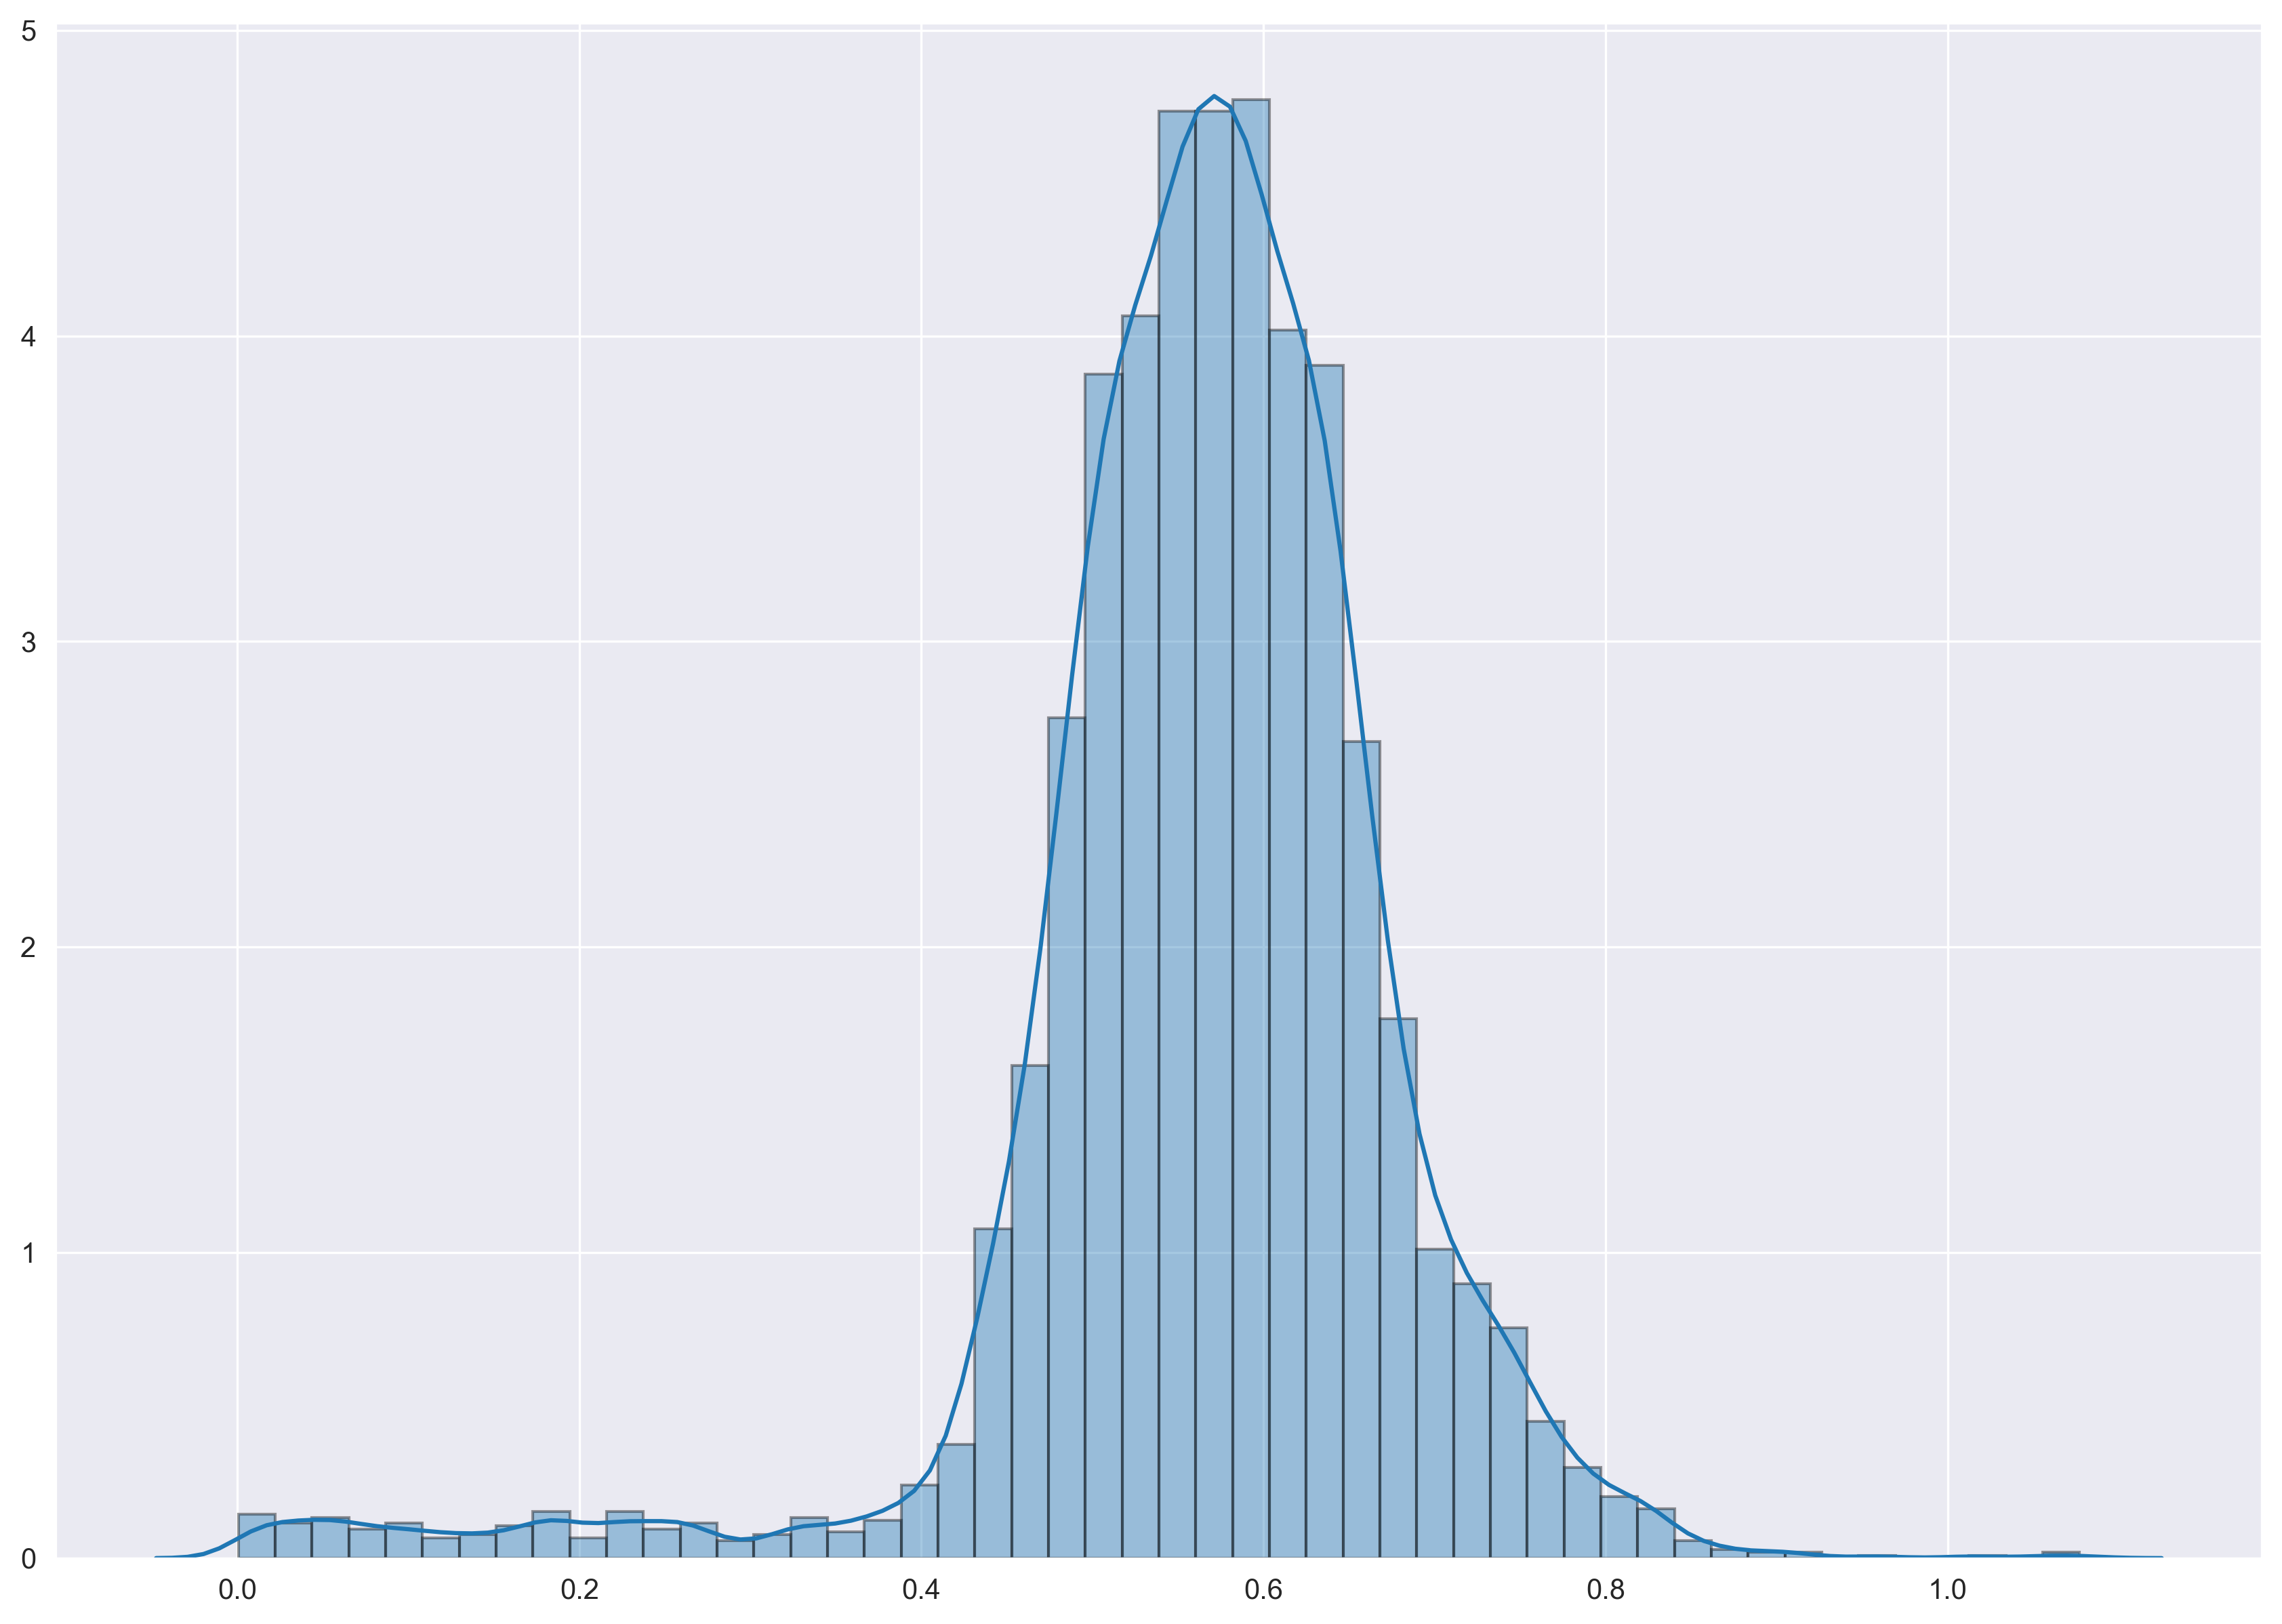

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

print(output[0][0].shape)
# test = np.unique(output[0][0])
test = output[0][10].flatten()
test = test[test > 0]

sns.set_style('darkgrid')
fig = sns.distplot( test, kde=True, hist=True, norm_hist = True, hist_kws={'edgecolor':'black'})

In [ ]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
#import argparse
import imutils
import cv2

def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

In [233]:
import cv2
import matplotlib.pyplot as plt
import os, glob

times = [time for time in range(24)]
areas, areas_land, areas_ocean = [None]*24, [None]*24, [None]*24

for i in tqdm(range(len(data_df))):
    time = int(data_df.hour[i])
    
    # Load image, grayscale, Gaussian blur, Otsu's threshold
    data = openVariable(data_df.path[i], '')
    image = (data[:,:,0] * 255).round().astype(np.uint8)
    image = cv2.resize(image, (data.shape[0], data.shape[1]))
    
    blur = cv2.GaussianBlur(image, (5,5), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # Get contours of shapes
    thresh_land, thresh_ocean = thresh.copy(), thresh.copy()
    thresh_land[data[:,:,1] < 0.02] = 255
    thresh_ocean[data[:,:,1] > 0.02] = 255
    
    # Get areas of all shapes and remove last one (background)
    if areas[time] is None: areas[time], areas_land[time], areas_ocean[time] = [], [], []

    im2,_ = cv2.findContours(thresh, 1, 2)
    areas[time].extend([cv2.contourArea(im) for im in im2][:-1])
    
    im2,_ = cv2.findContours(thresh_land, 1, 2)
    areas_land[time].extend([cv2.contourArea(im) for im in im2][:-1])
    
    im2,_ = cv2.findContours(thresh_ocean, 1, 2)
    areas_ocean[time].extend([cv2.contourArea(im) for im in im2][:-1])
    
#     plt.imshow(thresh, cmap='gray')
#     plt.axis('off')
#     plt.show()    


data = {
    'time': times,
    'area': areas,
    'area_land': areas_land,
    'area_ocean': areas_ocean
}

areas_df = pd.DataFrame(data, columns=['time', 'area', 'area_land', 'area_ocean'])
   

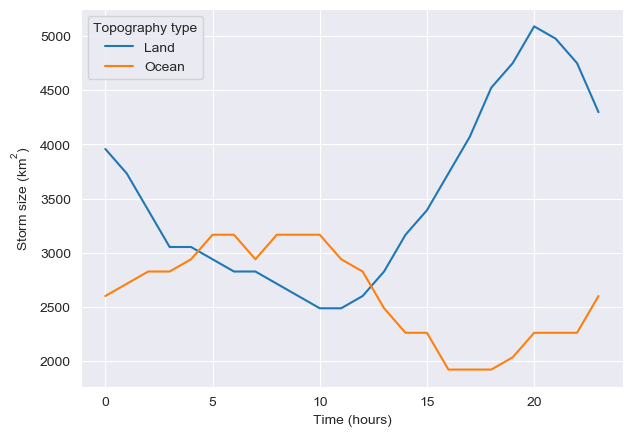

In [273]:
data_f = {
    'time': times,
    'area_land': [np.percentile(area, 50)*(4445*3334/256**2) for area in areas_df.area_land],
    'area_ocean': [np.percentile(area, 50)*(4445*3334/256**2) for area in areas_df.area_ocean]
}
data_f = pd.DataFrame(data_f, columns=['time', 'area_land', 'area_ocean'])

# %matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
sns.set_style('darkgrid')
fig = sns.lineplot(x='time', y='value', hue='variable', data=pd.melt(data_f, ['time']))
fig.set(xlabel='Time (hours)', ylabel='Storm size ($\mathregular{km^2}$)')
plt.legend(title='Topography type', loc='upper left', labels=['Land', 'Ocean'])


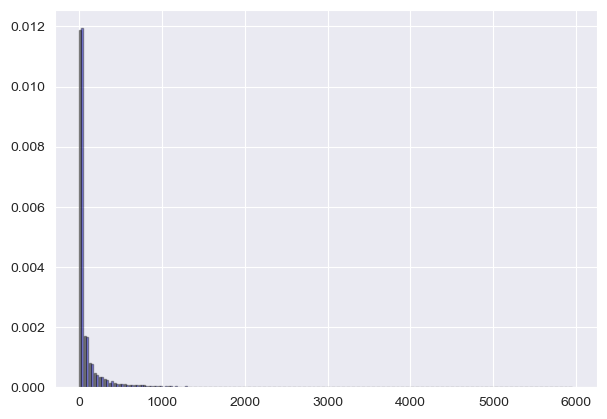

In [275]:
import seaborn as sns

sns.distplot(areas[:2], hist=True, kde=False, 
             bins=int(500/5), color = ['black', 'blue'], norm_hist = True,
             hist_kws={'edgecolor':'black'})

Move track

In [200]:
# import the necessary packages
from collections import deque
from imutils import perspective
from imutils import contours
import numpy as np
#import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

In [29]:
# define the lower and upper boundaries of the "green"
# ball in the HSV color space
greenLower = (0, 0, 15)
greenUpper = (0, 0, 255)

# initialize the list of tracked points, the frame counter,
# and the coordinate deltas
pts = deque(maxlen=25)
counter = 0
(dX, dY) = (0, 0)
direction = ""

i - 0
i - 1
i - 2


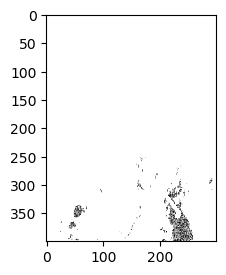

i - 3


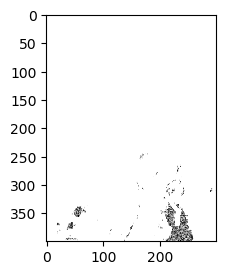

i - 4


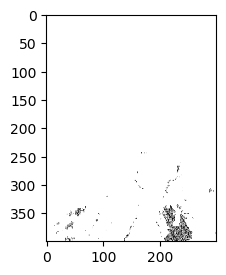

i - 5


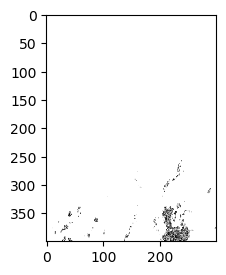

i - 6


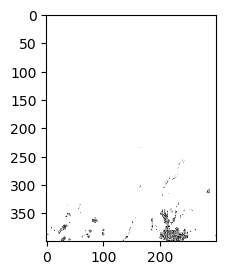

i - 7


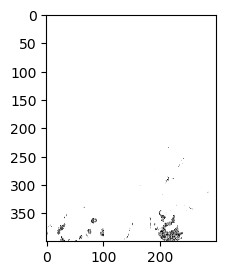

i - 8


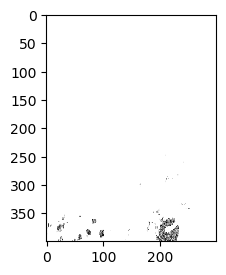

i - 9


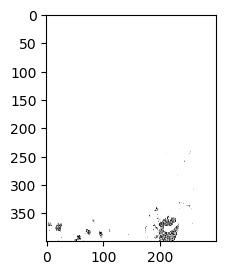

In [90]:
filenames = [filename for filename in os.listdir(data_filtered) if filename.startswith("BT")]

for j in range(10):
    print('i - ' + str(j))
    
    # Load image, grayscale, Gaussian blur, Otsu's threshold
    data = openVariable(data_filtered, filenames[j*2])
    image = (data * 255).round().astype(np.uint8)
    image = cv2.resize(image, (data.shape[0], data.shape[1]))
    
    color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    gray = cv2.cvtColor(color, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(gray, (7,7), 0)

    mask = cv2.inRange(blur, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    
    contours = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = contours[0] if len(contours) == 2 else contours[1]
    center = None
    
    #print(len(cnts))
    #print([cv2.contourArea(im) for im in cnts])
    #plt.imshow(mask, cmap='gray')
    #plt.show()
    
    if len(cnts) > 0:
        # find the largest contour in the mask, then use
        # it to compute the minimum enclosing circle and
        # centroid
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        # only proceed if the radius meets a minimum size
        if radius > 10:
            # draw the circle and centroid on the frame,
            # then update the list of tracked points
            cv2.circle(image, (int(x), int(y)), int(radius),
                (0, 255, 255), 2)
            cv2.circle(image, center, 5, (0, 0, 255), -1)
            pts.appendleft(center)
            
    # loop over the set of tracked points
    for i in np.arange(1, len(pts)):
        # if either of the tracked points are None, ignore
        # them
        if pts[i - 1] is None or pts[i] is None:
            continue
        # check to see if enough points have been accumulated in
        # the buffer
        #if counter >= 10 and i == 1 and pts[-10] is not None:
        if counter >= 2 and i == 1 and pts[-2] is not None:
            # compute the difference between the x and y
            # coordinates and re-initialize the direction
            # text variables
            dX = pts[i-1][0] - pts[i][0]
            dY = pts[i][1] - pts[i-1][1]
            (dirX, dirY) = ("", "")
            # ensure there is significant movement in the
            # x-direction
            if np.abs(dX) > 20:
                dirX = "East" if np.sign(dX) == 0 else "West"
            # ensure there is significant movement in the
            # y-direction
            if np.abs(dY) > 20:
                dirY = "North" if np.sign(dY) == 1 else "South"
            # handle when both directions are non-empty
            if dirX != "" and dirY != "":
                direction = "{}-{}".format(dirY, dirX)
            # otherwise, only one direction is non-empty
            else:
                direction = dirX if dirX != "" else dirY
                
        # otherwise, compute the thickness of the line and
        # draw the connecting lines
        thickness = int(np.sqrt(25 / float(i + 1)) * 2.5)
        cv2.line(image, pts[i - 1], pts[i], (0, 0, 255), thickness)
    
    # show the movement deltas and the direction of movement on
    # the frame
    #if counter >= 10:
    if counter >= 2:
        #print(direction)
        #print("dx: {}, dy: {}".format(dX, dY))
        # show the frame to our screen and increment the frame counter
        image = (image - 255) * -1
        plt.imshow(image, cmap='gray')
        plt.show()
    counter += 1


In [197]:
def clean_image(image, lowerBoundary, upperBoundary):
#     color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    mask = cv2.inRange(blur, lowerBoundary, upperBoundary)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    thresh = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return mask, thresh

def filter_areas(image, img_height_5, img_widht_5):
    # Filter by areas
    img_ocean, img_mainland, img_mountains = mask.copy(), mask.copy(), mask.copy()
    # Filter by Ocean (-20W to -15W and whole height, -20W to 10E and 0 to 5N)
    img_ocean[:round(4.75*img_height_5), img_widht_5:] = 0
    img_ocean[-round(1.25*img_height_5):, :-2*img_widht_5] = 0
    # Filter by Mainland
    img_mainland[:, :img_widht_5] = 0
    img_mainland[:3*img_height_5, round(4.5*img_widht_5):] = 0
    img_mainland[-round(1.25*img_height_5):, :-2*img_widht_5] = 0
    # Filter by Mountains (0 to 20E and 15 to 30N)
    img_mountains[:, :round(4.5*img_widht_5)] = 0
    img_mountains[3*img_height_5:, round(4.5*img_widht_5):] = 0
    
    return img_ocean, img_mainland, img_mountains

def filter_areas(mask, img_height_5, img_widht_5):
    # Filter by areas
    img_ocean, img_mainland, img_mountains = mask.copy(), mask.copy(), mask.copy()
    # Filter by Ocean (-20W to -15W and whole height, -20W to 10E and 0 to 5N)
    img_ocean[2*img_height_5:, :] = 0
    # Filter by Mainland
    img_mainland[:2*img_height_5, :] = 0
    img_mainland[4*img_height_5:, :] = 0
    # Filter by Mountains (0 to 20E and 15 to 30N)
    img_mountains[:4*img_height_5, :] = 0
    
    return img_ocean, img_mainland, img_mountains

def getBiggestCloud(mask):
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    if(len(cnts) > 0): return max(cnts, key=cv2.contourArea)
    else: return None
    
def getCenter(contour, image, radius_min = 10, mode = 0):
    # find the largest contour in the mask, then use it to compute the minimum enclosing circle and centroid
    ((x, y), radius) = cv2.minEnclosingCircle(contour)
    M = cv2.moments(contour)
    
    # only proceed if the radius meets a minimum size
    if radius < radius_min or M["m00"] == 0: return None
    
    # Center
    if mode == 0:
        return (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    # Most left
    elif mode == 1: 
        return tuple(contour[contour[:,:,0].argmin()][0])
    # Point with highest value
    elif mode == 2:
        mask = np.zeros_like(image)
        cv2.fillPoly(mask, pts =[contour], color=(255,255,255))
        
        points = np.where(mask == 255)
        pixels = [0,0]
        pixel_value = 0
        for i in range(len(points[0])):
            tmp = image[points[0][i], points[1][i]][0]
            if tmp > pixel_value: 
                pixels = [points[1][i], points[0][i]]
                pixel_value = tmp
        return tuple(pixels)



def getMovement(pts, image = None):
    for i in np.arange(1, len(pts)):
        # if either of the tracked points are None, ignore them
        if pts[i - 1] is None or pts[i] is None:
            continue
        # check to see if enough points have been accumulated in the buffer
        if i == 1 and pts[-2] is not None:
            # compute the difference between the x and y
            dX = pts[i-1][0] - pts[i][0]
            dY = pts[i][1] - pts[i-1][1]
                
            # Check same cloud
            if abs(dX) > 4 or abs(dY) > 4: 
                return None, None, image
        
        # otherwise, compute the thickness of the line and draw the connecting lines
        if image is not None:
            thickness = int(np.sqrt(10 / float(i + 1)) * 2.5)
            cv2.line(image, pts[i - 1], pts[i], (255, 0, 0), thickness)
        else:
            break
    
    return dX, dY, image    

def computeDirections(mode = 0):

#     filenames = [filename for filename in os.listdir(data_filtered) if filename.startswith("BT")]
    lowerBoundary, upperBoundary = (0, 0, 15), (0, 0, 255)
    pts, pts_ocean, pts_main, pts_moutains = deque(maxlen=25), deque(maxlen=25), deque(maxlen=25), deque(maxlen=25)
    dA, dA_ocean, dA_main, dA_mountain = [], [], [], []

    # for i in tqdm(range(len(filenames))):
    for i in tqdm(range(len(valid_indexes))):
#     for i in tqdm(range(len(data_df))):
        # Load image, grayscale, Gaussian blur, Otsu's threshold
    #     data = openVariable(data_filtered, filenames[xxxxxx + i*2])
        data = openVariable(data_df.path[valid_indexes[i]], '')[:,:,0]
#         data = openVariable(data_df.path[i], '')[:,:,0]
    #     data = output[0, i]

        # Normalize
        if type(data[0,0]) is not np.uint8:
            f_min, f_max = np.amin(data), np.amax(data)
            if f_min == f_max: image = data.round().astype(np.uint8)
            else:
                data = (data - f_min) / (f_max - f_min)
                image = (data * 255).round().astype(np.uint8)
        else: image = data

    #     image = cv2.resize(image, (data.shape[0], data.shape[1]))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        img_width = len(image[0])
        img_widht_5 = int(img_width / 8)
        img_height = len(image)
        img_height_5 = int(img_height / 6)

        mask, thresh = clean_image(image, lowerBoundary, upperBoundary)
        mask_ocean, mask_mainland, mask_mountain = filter_areas(mask, img_height_5, img_widht_5)

        cnt = getBiggestCloud(mask)
        cnt_ocean = getBiggestCloud(mask_ocean)
        cnt_mainland = getBiggestCloud(mask_mainland)
        cnt_mountains = getBiggestCloud(mask_mountain)

        if cnt is not None: 
            center = getCenter(cnt, image, 12, mode = mode)
            if center is not None: pts.appendleft(center)
            else: pts_ocean.clear()
        else: pts.clear()
        if (len(pts) >= 2):
            dX, dY, image = getMovement(pts, image)
            if dX is not None:
                dA.append([dX, dY, cv2.contourArea(cnt)])
            else:
                pts.clear()

        if cnt_ocean is not None: 
            center = getCenter(cnt_ocean, image, 6, mode = mode)
            if center is not None: pts_ocean.appendleft(center)
            else: pts_ocean.clear()
        else: pts_ocean.clear()
        if (len(pts_ocean) >= 2):
            dX, dY, image = getMovement(pts_ocean, image)
            if dX is not None:
                dA_ocean.append([dX, dY, cv2.contourArea(cnt_ocean)])
            else:
                pts_ocean.clear()

        if cnt_mainland is not None: 
            center = getCenter(cnt_mainland, image, 6, mode = mode)
            if center is not None: pts_main.appendleft(center)
            else: pts_main.clear()
        else: pts_main.clear()
        if (len(pts_main) >= 2):
            dX, dY, image = getMovement(pts_main, image)
            if dX is not None:
                dA_main.append([dX, dY, cv2.contourArea(cnt_mainland)])
            else:
                pts_main.clear()

        if cnt_mountains is not None: 
            center = getCenter(cnt_mountains, image, 6, mode = mode)
            if center is not None: pts_moutains.appendleft(center)
            else: pts_moutains.clear()
        else: pts_moutains.clear()
        if (len(pts_moutains) >= 2):
            dX, dY, image = getMovement(pts_moutains, image)
            if dX is not None:
                dA_mountain.append([dX, dY, cv2.contourArea(cnt_mountains)])
            else:
                pts_moutains.clear()


        # show the movement deltas and the direction of movement on
        # the frame
        image = None
        if image is not None:
            # show the frame to our screen and increment the frame counter
            plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':100})
            plt.imshow(image)
            plt.axis('off')
            plt.show()
    #         break   ##########################################################################################

    #print("dA: {}".format(dA_ocean))
    #print("dx: {}".format(dA_main))
    #print("dx: {}".format(dA_mountain))
    return dA, dA_ocean, dA_main, dA_mountain


In [202]:
conv_width_p2km = 4445 / 256
conv_height_p2km = 3334 / 256
vectors = []

dA, dA_top, dA_middle, dA_bottom = computeDirections(mode = 0)

dA_vector = np.sum(dA_top, axis=0) / len(dA_top)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
dA_vector = np.sum(dA_middle, axis=0) / len(dA_middle)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
dA_vector = np.sum(dA_bottom, axis=0) / len(dA_bottom)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
print(vectors[-3:])

dA, dA_top, dA_middle, dA_bottom = computeDirections(mode = 1)

dA_vector = np.sum(dA_top, axis=0) / len(dA_top)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
dA_vector = np.sum(dA_middle, axis=0) / len(dA_middle)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
dA_vector = np.sum(dA_bottom, axis=0) / len(dA_bottom)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
print(vectors[-3:])

dA, dA_top, dA_middle, dA_bottom = computeDirections(mode = 2)

dA_vector = np.sum(dA_top, axis=0) / len(dA_top)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
dA_vector = np.sum(dA_middle, axis=0) / len(dA_middle)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
dA_vector = np.sum(dA_bottom, axis=0) / len(dA_bottom)
vectors.append(complex(dA_vector[0]*conv_width_p2km, dA_vector[1]*conv_height_p2km))
print(vectors[-3:])


[(10.653902932590233+2.502380241507431j), (-18.50575897446881-1.44159366432488j), (-15.037578946252967-1.8548130722278737j)]



[(8.478164672851562+3.900248209635417j), (-17.16742645065076-0.11865170824295011j), (-12.843970233679526-0.2925994860110216j)]



[(9.598513562293729+3.5030038160066006j), (-14.022148938607208+3.3891169059254733j), (-10.257515985973598+5.1921823432343235j)]


[(10.653902932590233+2.502380241507431j), (-18.50575897446881-1.44159366432488j), (-15.037578946252967-1.8548130722278737j), (8.478164672851562+3.900248209635417j), (-17.16742645065076-0.11865170824295011j), (-12.843970233679526-0.2925994860110216j), (9.598513562293729+3.5030038160066006j), (-14.022148938607208+3.3891169059254733j), (-10.257515985973598+5.1921823432343235j)]


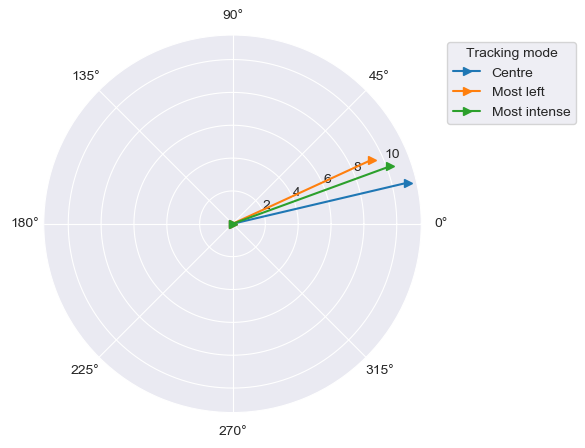

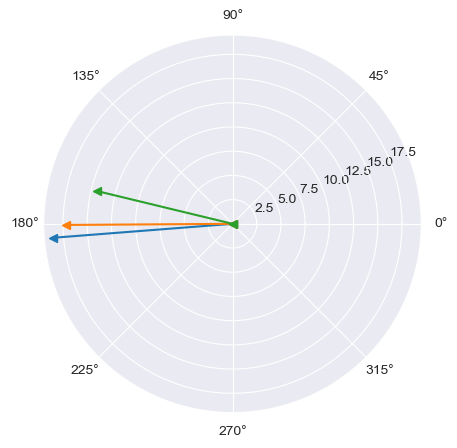

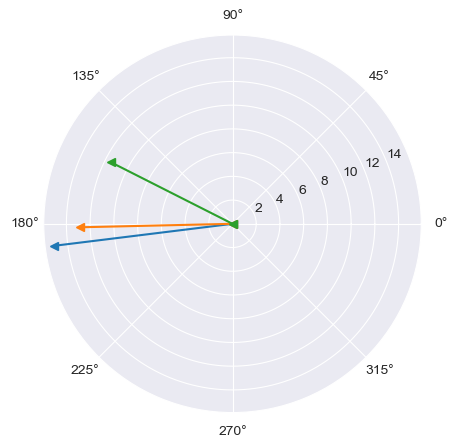

In [203]:
print(vectors)
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.figure()
for x in [vectors[i] for i in [0, 3, 6]]:
    if abs(math.degrees(cmath.phase(x))) < 90:
        plt.polar([0,cmath.phase(x)],[0,abs(x)], marker='>')
    else:
        plt.polar([0,cmath.phase(x)],[0,abs(x)],marker='<')
    plt.legend(title='Tracking mode', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['Centre', 'Most left', 'Most intense'])
#     plt.title('Storm tracking from 20 to 30 ºN', y=-0.15)
    
plt.figure()
for x in [vectors[i] for i in [1, 4, 7]]:
    if abs(math.degrees(cmath.phase(x))) < 90:
        plt.polar([0,cmath.phase(x)],[0,abs(x)], marker='>')
    else:
        plt.polar([0,cmath.phase(x)],[0,abs(x)],marker='<')
#     plt.legend(title='Tracking mode', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['Center', 'Mostleft', 'Most intense'])
#     plt.title('Storm tracking from 10 to 20 ºN', y=-0.15)
    
plt.figure()
for x in [vectors[i] for i in [2, 5, 8]]:
    if abs(math.degrees(cmath.phase(x))) < 90:
        plt.polar([0,cmath.phase(x)],[0,abs(x)], marker='>')
    else:
        plt.polar([0,cmath.phase(x)],[0,abs(x)],marker='<')
#     plt.legend(title='Tracking mode', bbox_to_anchor=(1.05, 1), loc='upper left', labels=['Center', 'Mostleft', 'Most intense'])
#     plt.title('Storm tracking from 0 to 10 ºN', y=-0.15)

Trainings

In [28]:
filenames = [
    'checkpoint_CNN_ReLu_#1__2to1__ep30',
    'checkpoint_CNN_ReLu_#4__2to1__ep30',
    'checkpoint_ConvLSTM_ReLu_#1__2to1__ep30',
    'checkpoint_ConvLSTM_ReLu_#4__2to1__ep30'
]
train_loss_loggers = []
eval_loss_loggers = []
lr_loggers = []

for fn in filenames:
    checkpoint = torch.load(model_dir + fn + '.ckpt')
    loss_logger = checkpoint['loss_logger']
    
    # Remove non-real valuesfor training logs
    indexes = [idx for idx, element in enumerate(loss_logger[0]) if element > 0.001]
    train_loss_loggers.append([loss_logger[0][idx] for idx in indexes])
    lr_loggers.append([loss_logger[2][idx] for idx in indexes])
    eval_loss_loggers.append(loss_logger[1])
    
for i in range(len(train_loss_loggers)):
    print(i)
    print(len(train_loss_loggers[i]), len(eval_loss_loggers[i]), len(lr_loggers[i]))

0
360 31 360
1
360 31 360
2
360 31 360
3
360 31 360


CNN #1


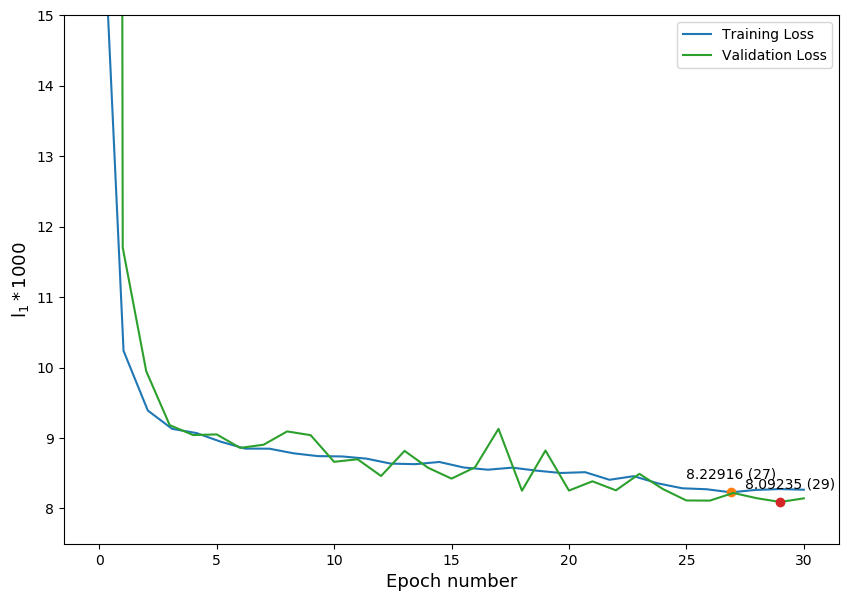

CNN #4


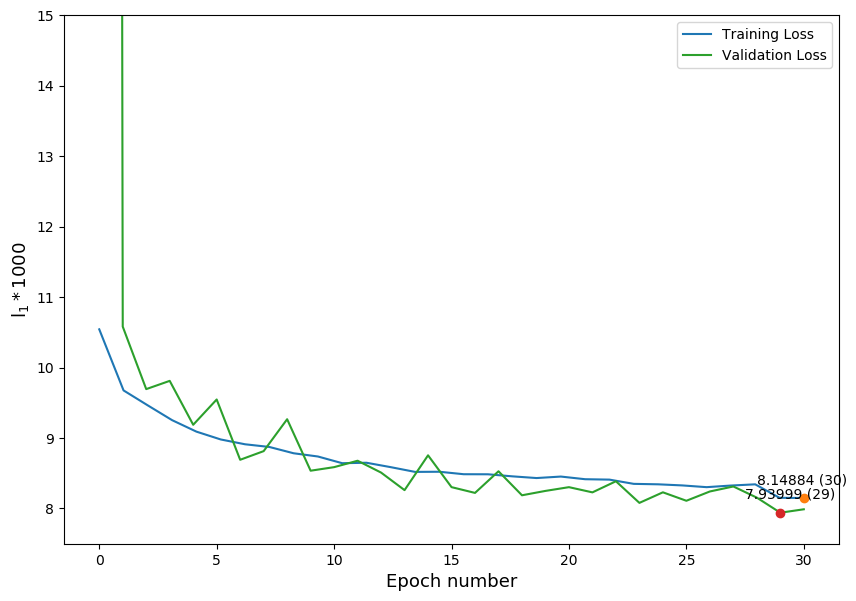

ConvLSTM #1


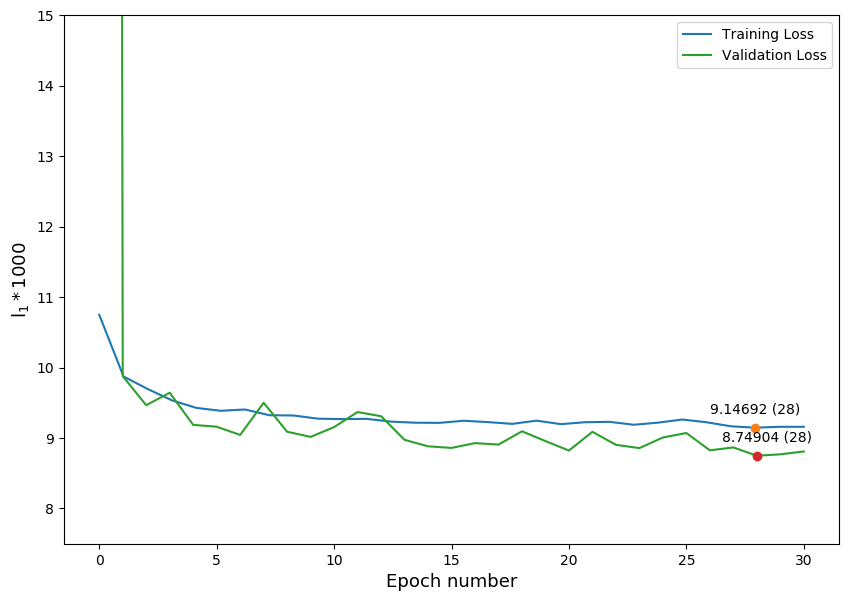

ConvLSTM #4


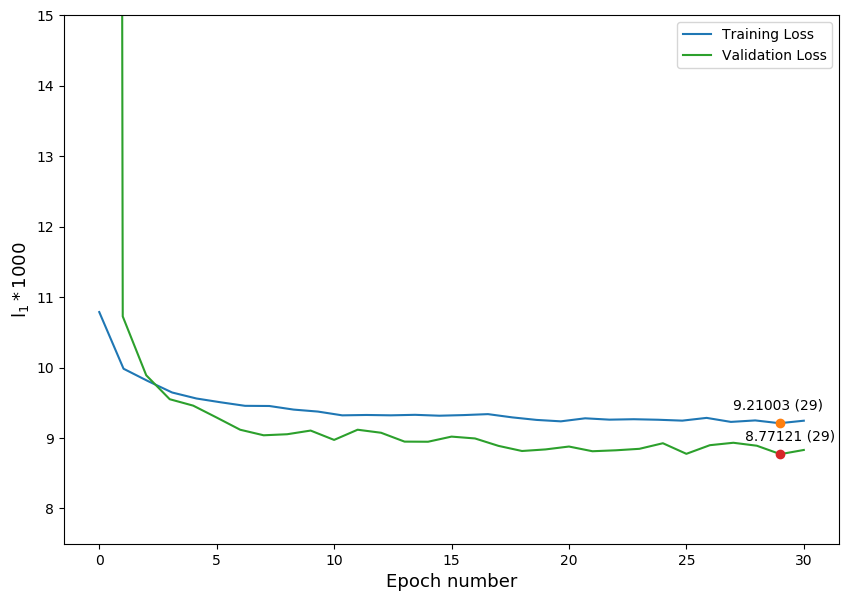

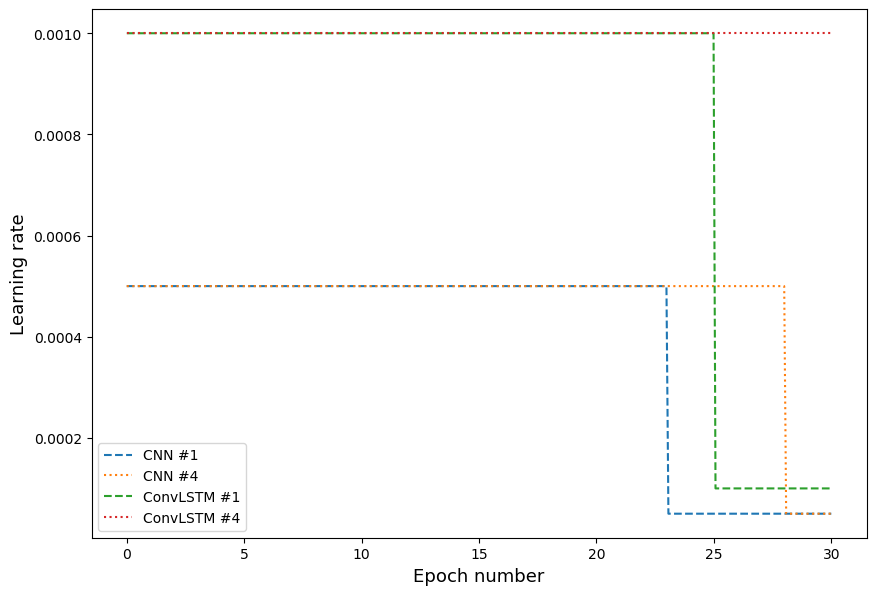

In [33]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':100})

num_epochs = 30

for fn in range(len(filenames)):

    print(filenames[fn])
    training_log = train_loss_loggers[fn]
    training_log = [loss*1000*0.85 for loss in training_log]
    evaluation_log = eval_loss_loggers[fn]
    evaluation_log = [loss*1000 for loss in evaluation_log]

    training_log = [sum(training_log[i*12:(i+1)*12])/12 for i in range(num_epochs)] # Train Loss Averaging

    x1 = np.linspace(0, num_epochs, len(training_log))
    x2 = np.linspace(0, num_epochs, len(evaluation_log))
    plt.figure()
    plt.plot(x1, training_log, label="Training Loss")
    plt.plot(x1, training_log, markevery=[training_log.index(min(training_log))], ls="", marker="o")
    plt.text(training_log.index(min(training_log))-1, min(training_log) + 0.2, f'{min(training_log):.5f} ({training_log.index(min(training_log))+1})')
    plt.plot(x2, evaluation_log, label="Validation Loss")
    plt.plot(x2, evaluation_log, markevery=[evaluation_log.index(min(evaluation_log))], ls="", marker="o")
    plt.text(evaluation_log.index(min(evaluation_log))-1.5, min(evaluation_log) + 0.2, f'{min(evaluation_log):.5f} ({evaluation_log.index(min(evaluation_log))})')
    plt.ylim((7.5, 15))
    plt.xlabel("Epoch number", fontsize=13)
    plt.ylabel("$\mathregular{l_1*1000}$", fontsize=13)
    plt.legend(loc='upper right')
    plt.show()

filenames = ['CNN #1', 'CNN #4', 'ConvLSTM #1', 'ConvLSTM #4']
linestyles = ['--', ':', '--', ':']
for fn in range(len(filenames)):
    lr_log = lr_loggers[fn]
    
    x1 = np.linspace(0, num_epochs, len(lr_log))
    plt.plot(x1, lr_log, label=filenames[fn], linestyle=linestyles[fn])
    
plt.xlabel("Epoch number", fontsize=13)
plt.ylabel("Learning rate", fontsize=13)
plt.legend(loc='best')
plt.show()

Evaluators Graphs

In [328]:
filenames = [
    'evaluators_CNN_#1__2to1__EVAL',
    'evaluators_CNN_#4__2to1__EVAL',
    'evaluators_ConvLSTM_#1__2to1__EVAL',
    'evaluators_ConvLSTM_#4__2to1__EVAL'
]

eval_loss_loggers = []
psnr_loggers = []
ssim_loggers = []
fss_loggers = []
cloud_loggers = []
move_loggers_0, move_loggers_1, move_loggers_2 = [], [], []

for i in range(len(filenames)):
    print(filenames[i])
    fn = filenames[i]
    
    evaluators = openVariable(model_dir, fn)
    
    eval_loss_loggers.append([ev.Loss()*1000*8 for ev in evaluators])
    psnr_loggers.append([ev.PSNR() for ev in evaluators])
    ssim_loggers.append([ev.SSIM() for ev in evaluators])
    fss_loggers.append([ev.FSS() for ev in evaluators])
    cloud_loggers.append([ev.CloudSize()*(4445*3334/256**2) for ev in evaluators])
    move_loggers_0.append([ev.MovingDistance(3,0) for ev in evaluators])
    move_loggers_1.append([ev.MovingDistance(3,1) for ev in evaluators])
    move_loggers_2.append([ev.MovingDistance(3,2) for ev in evaluators])
    
for i in range(len(eval_loss_loggers)):
    print(filenames[i])
    print(len(eval_loss_loggers[i]), len(psnr_loggers[i]), len(ssim_loggers[i]), len(fss_loggers[i]))
    print(len(cloud_loggers[i]), len(move_loggers_0[i]), len(move_loggers_1[i]), len(move_loggers_2[i]))

evaluators_CNN_#1__2to1__EVAL
evaluators_CNN_#4__2to1__EVAL
evaluators_ConvLSTM_#1__2to1__EVAL
evaluators_ConvLSTM_#4__2to1__EVAL
evaluators_CNN_#1__2to1__EVAL
10 10 10 10
10 10 10 10
evaluators_CNN_#4__2to1__EVAL
10 10 10 10
10 10 10 10
evaluators_ConvLSTM_#1__2to1__EVAL
10 10 10 10
10 10 10 10
evaluators_ConvLSTM_#4__2to1__EVAL
10 10 10 10
10 10 10 10


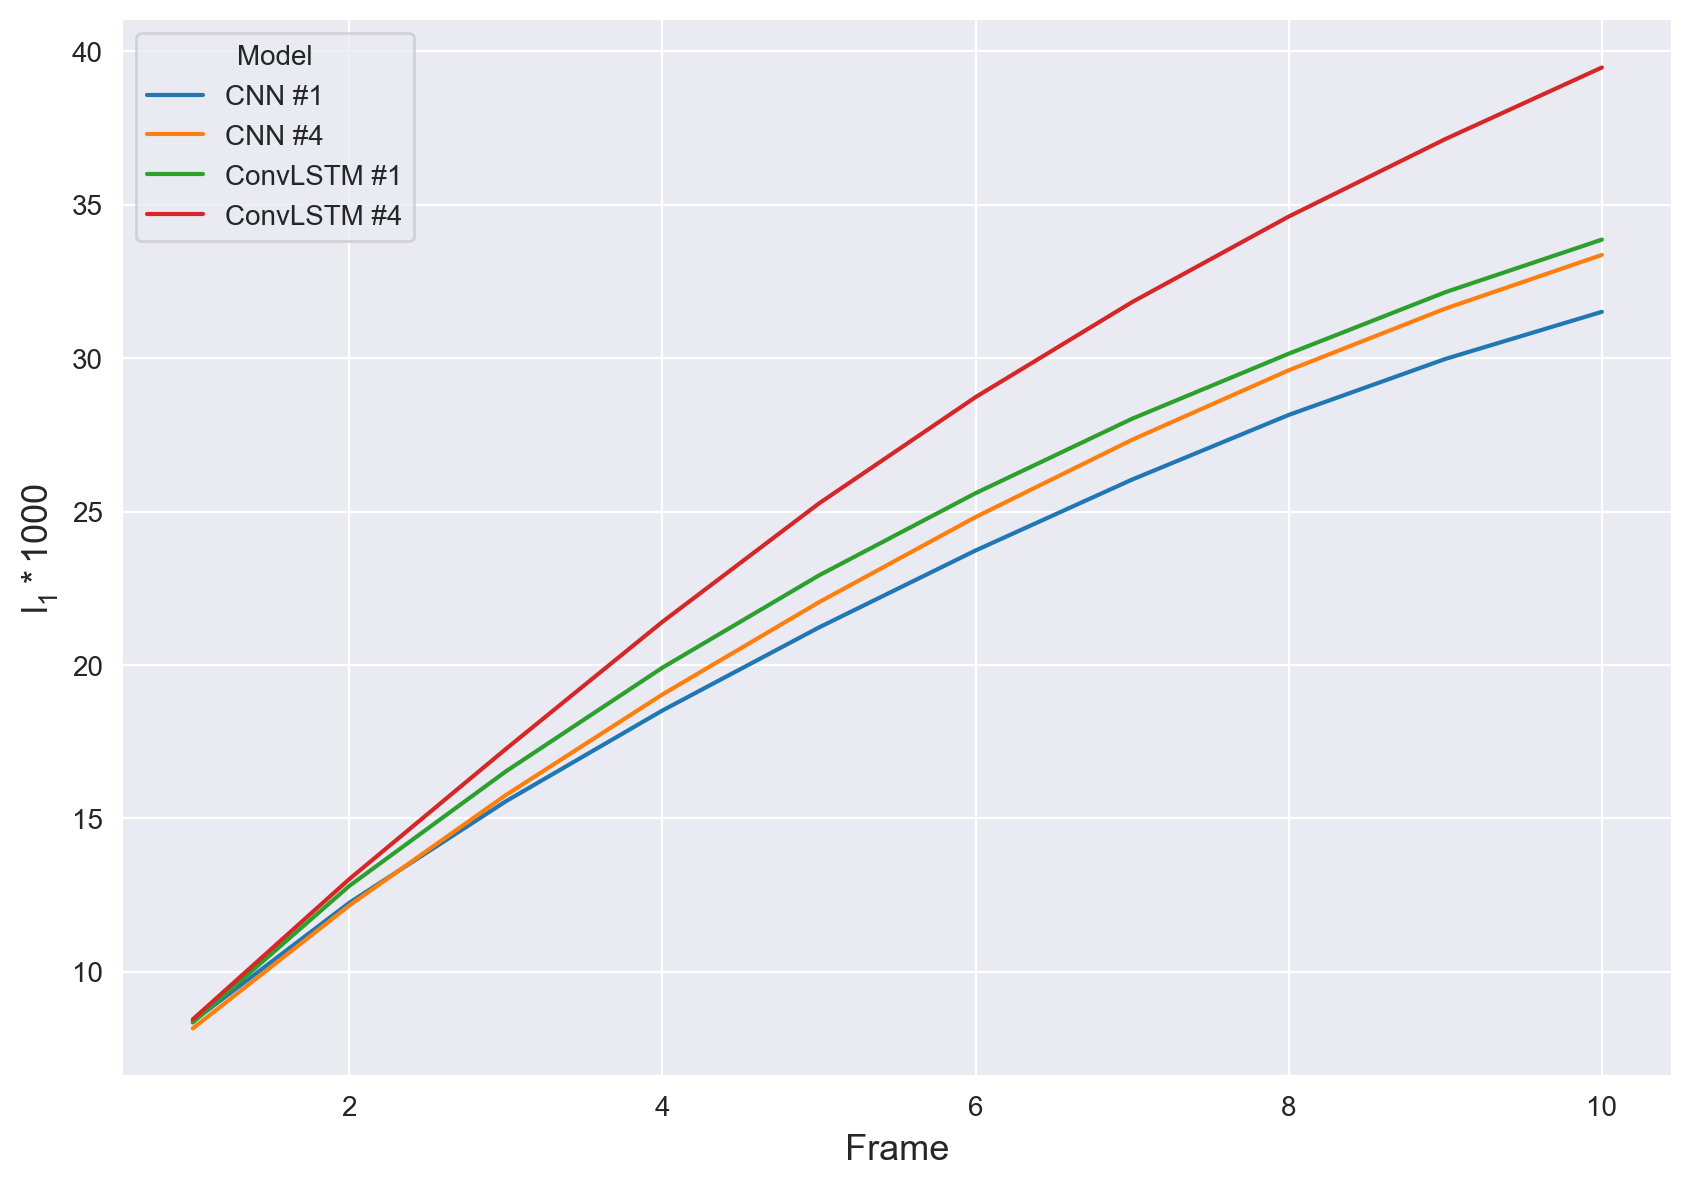

In [249]:
tmp = eval_loss_loggers

data_f = {
    'frame': list(np.arange(1,11)),
    'cnn_1': tmp[0],
    'cnn_4': tmp[1],
    'convLSTM_1': tmp[2],
    'convLSTM_4': tmp[3]
}
data_f = pd.DataFrame(data_f, columns=['frame', 'cnn_1', 'cnn_4', 'convLSTM_1', 'convLSTM_4'])

# %matplotlib inline
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':200})
sns.set_style('darkgrid')
fig = sns.lineplot(x='frame', y='value', hue='variable', data=pd.melt(data_f, ['frame']))
plt.ylabel("$\mathregular{l_1*1000}$", fontsize=13)
# plt.ylabel("PSNR (dB)", fontsize=13)
# plt.ylabel("SSIM", fontsize=13)
# plt.ylabel("Storm size ($\mathregular{km^2}$)", fontsize=13)
plt.xlabel("Frame", fontsize=13)
plt.legend(title='Model', loc='best', labels=['CNN #1', 'CNN #4', 'ConvLSTM #1', 'ConvLSTM #4'])

[0.9329038879667194, 0.9329038879667194, 0.9692242447619825, 0.9802730122178323, 0.9880602482502076, 0.9909002614028866]
[0.8678029376679792, 0.8678029376679792, 0.9227569714908881, 0.9452351124896706, 0.9642126041718265, 0.9722107190234225]
[0.799437724575148, 0.799437724575148, 0.8631476558935708, 0.8951738461485891, 0.9266723717102193, 0.9416077017866809]
[0.7309956682538401, 0.7309956682538401, 0.7970167848943667, 0.8353458921853901, 0.8781571750913152, 0.9006537574512614]
[0.6647551122451635, 0.6647551122451635, 0.7299110768710735, 0.7716690013588875, 0.8233680391843439, 0.8531107851718273]
[0.602592729632105, 0.602592729632105, 0.6653676189296567, 0.7085480515306128, 0.766571695890627, 0.8026734103900839]
[0.5453318267882071, 0.5453318267882071, 0.6048846204549804, 0.6480836855205846, 0.7102118573630781, 0.7516150503727731]
[0.4947791824815484, 0.4947791824815484, 0.550483153660589, 0.5925095867457674, 0.6564156852585323, 0.7016867158313101]
[0.4520174071966358, 0.452017407196635

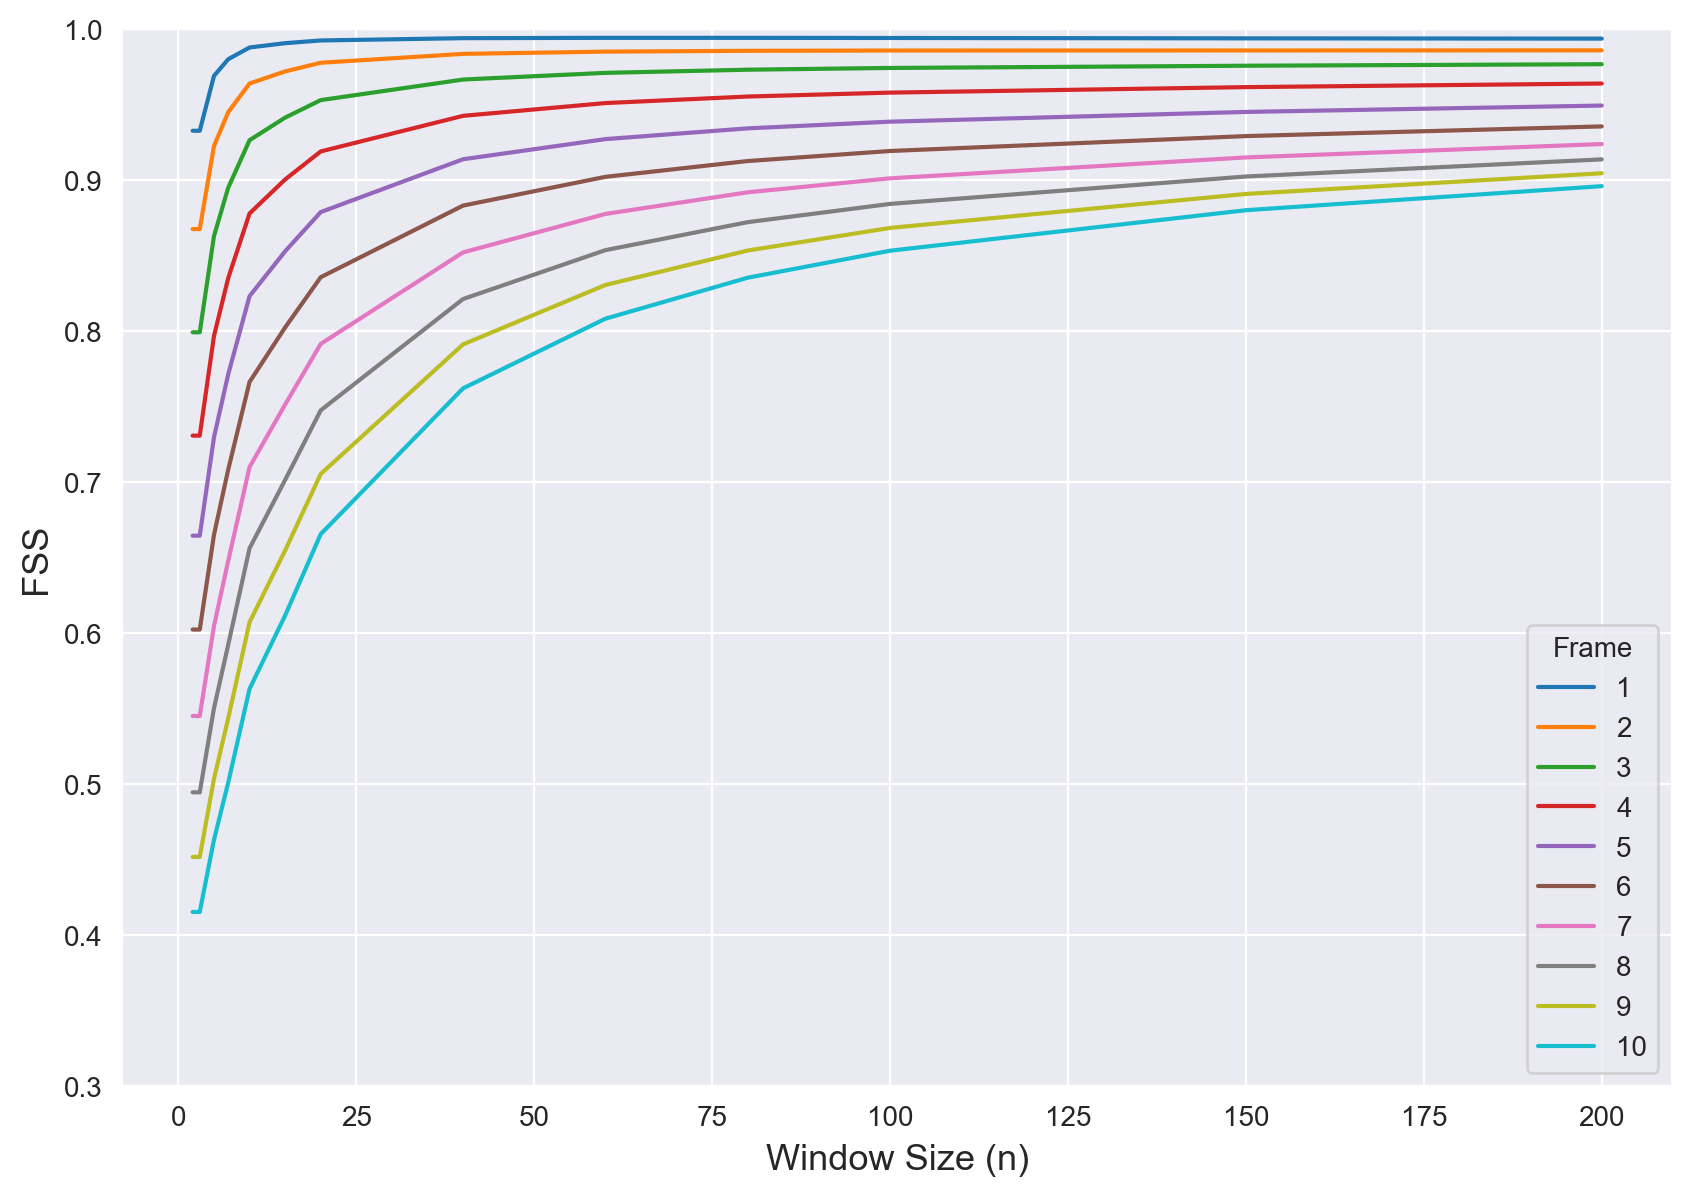

In [332]:
tmp = fss_loggers[3]

for i in range(10):
    print(tmp[i][0:6])

data_f = {
    'window': [2, 3, 5, 7, 10, 15, 20, 40, 60, 80, 100, 150, 200],
    'f1': tmp[0],
    'f2': tmp[1],
    'f3': tmp[2],
    'f4': tmp[3],
    'f5': tmp[4],
    'f6': tmp[5],
    'f7': tmp[6],
    'f8': tmp[7],
    'f9': tmp[8],
    'f10': tmp[9]
}
data_f = pd.DataFrame(data_f, columns=['window', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'])

# %matplotlib inline
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':200})
sns.set_style('darkgrid')
fig = sns.lineplot(x='window', y='value', hue='variable', data=pd.melt(data_f, ['window']))
fig.set(ylim=(0.30, 1))

plt.ylabel("FSS", fontsize=13)
plt.xlabel("Window Size (n)", fontsize=13)
plt.legend(title='Frame', loc='best', labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

evaluators_CNN_#1__2to1__EVAL


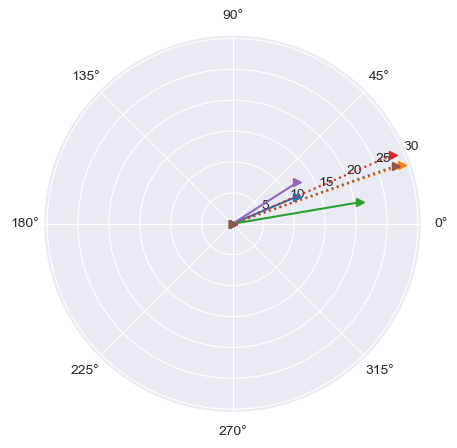

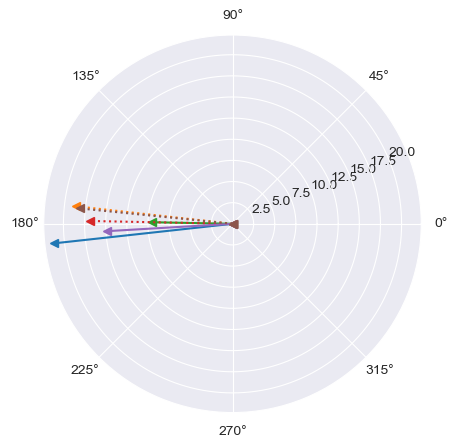

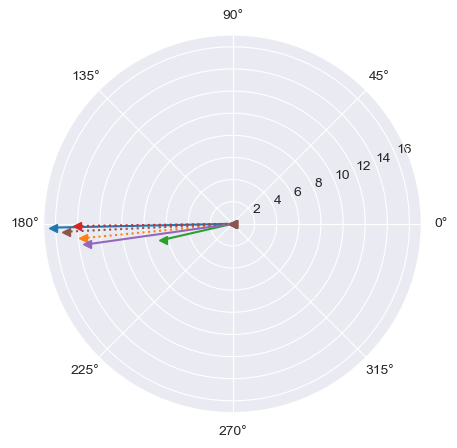

evaluators_CNN_#4__2to1__EVAL


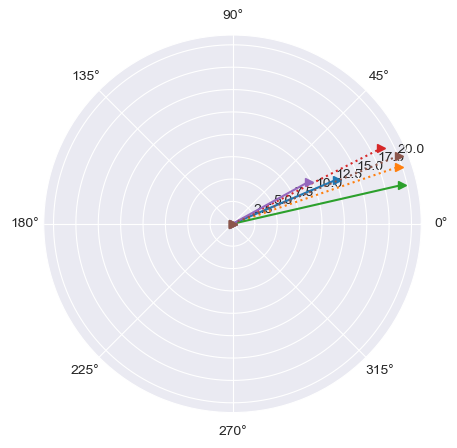

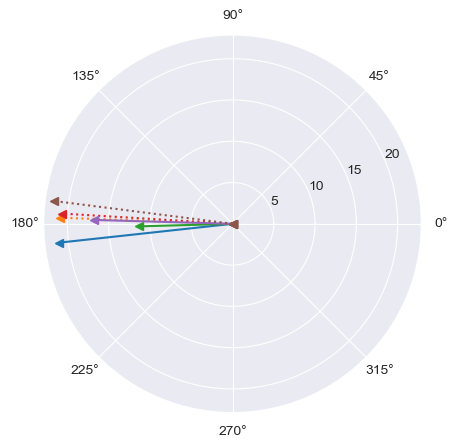

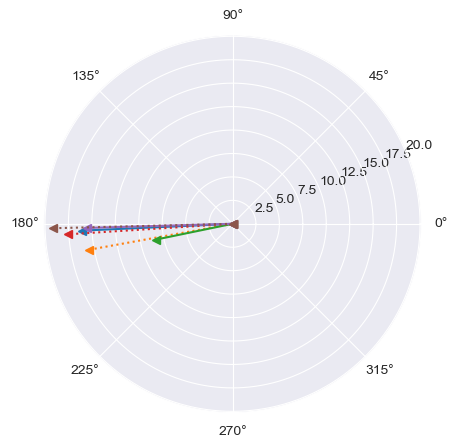

evaluators_ConvLSTM_#1__2to1__EVAL


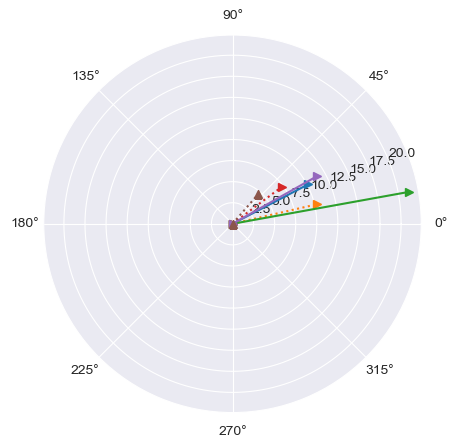

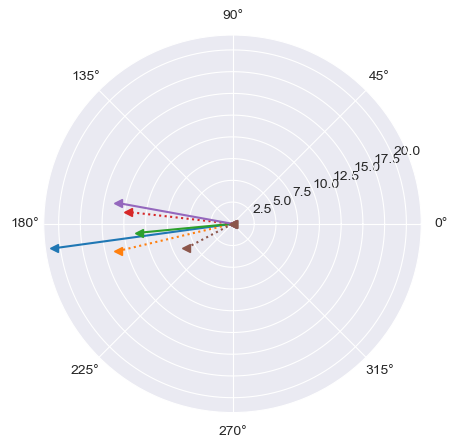

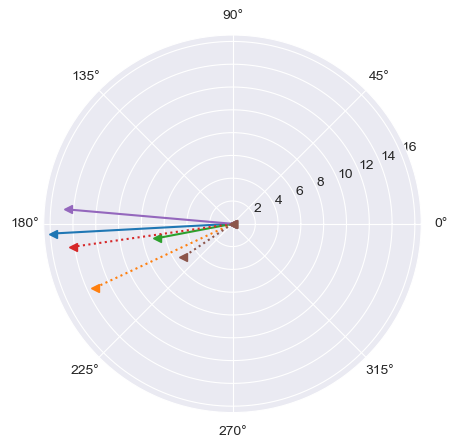

evaluators_ConvLSTM_#4__2to1__EVAL


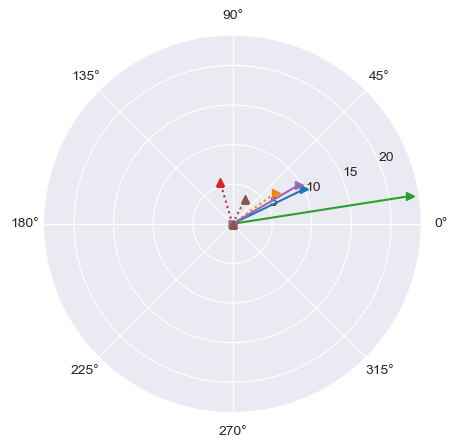

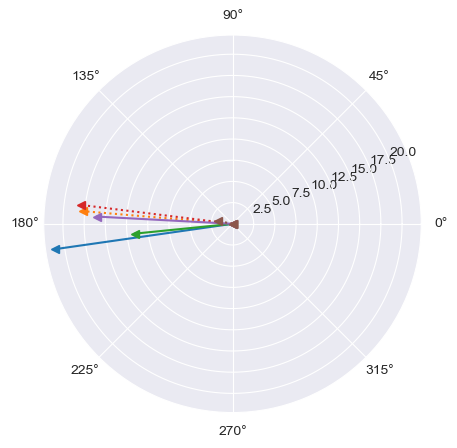

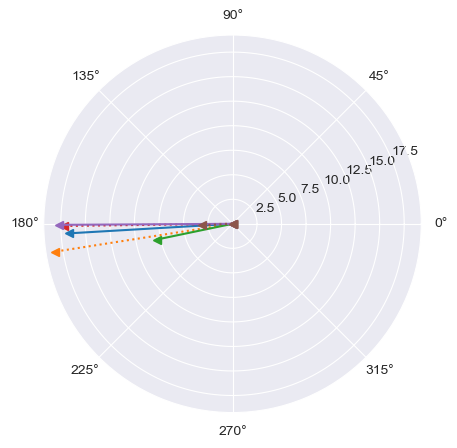

In [269]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
for fn_idx in range(len(filenames)):
    print(filenames[fn_idx])
    for i in range(1,4):
        vectors = [
            move_loggers_0[fn_idx][0][i], move_loggers_0[fn_idx][9][i],
            move_loggers_1[fn_idx][0][i], move_loggers_1[fn_idx][9][i], 
            move_loggers_2[fn_idx][0][i], move_loggers_2[fn_idx][9][i]
        ]
        
        plt.figure()
        linestyles = ['-', ':', '-', ':', '-', ':']
        for v in range(len(vectors)):
            vct = vectors[v]
            if abs(vct[1]) < 45:
                plt.polar([0,math.radians(vct[1])],[0,vct[0]], marker='>', linestyle=linestyles[v])
            elif vct[1] > 45 and vct[1] < 135:
                plt.polar([0,math.radians(vct[1])],[0,vct[0]], marker='^', linestyle=linestyles[v])
            else:
                plt.polar([0,math.radians(vct[1])],[0,vct[0]],marker='<', linestyle=linestyles[v])
#         plt.legend(title='Tracking mode', bbox_to_anchor=(1.05, 1), loc='upper left', 
#                    labels=['Centre $\mathregular{frame_1}$', 'Centre $\mathregular{frame_{10}}$', 
#                            'Most left $\mathregular{frame_1}$', 'Most left $\mathregular{frame_{10}}$', 
#                            'Most intense $\mathregular{frame_1}$', 'Most intense $\mathregular{frame_{10}}$'])
        plt.show()



Storm size

In [325]:
filenames = [
    'evaluators_CNN_#1__2to1__EVAL1',
    'evaluators_CNN_#4__2to1__EVAL1',
    'evaluators_ConvLSTM_#1__2to1__EVAL1',
    'evaluators_ConvLSTM_#4__2to1__EVAL1'
]

cloud_loggers_0_land, cloud_loggers_0_ocean = [], []
cloud_loggers_6_land, cloud_loggers_6_ocean = [], []
cloud_loggers_12_land, cloud_loggers_12_ocean = [], []
cloud_loggers_18_land, cloud_loggers_18_ocean = [], []

for i in range(len(filenames)):
    print(filenames[i])
    fn = filenames[i]
    
    evaluators = openVariable(model_dir, fn)
    
    cloud_loggers_0_ocean.append([ev.CloudSize(0) for ev in evaluators[0]])
    cloud_loggers_0_land.append([ev.CloudSizeTarget(0) for ev in evaluators[0]])
    cloud_loggers_6_ocean.append([ev.CloudSize(0) for ev in evaluators[1]])
    cloud_loggers_6_land.append([ev.CloudSizeTarget(0) for ev in evaluators[1]])
    cloud_loggers_12_ocean.append([ev.CloudSize(0) for ev in evaluators[2]])
    cloud_loggers_12_land.append([ev.CloudSizeTarget(0) for ev in evaluators[2]])
    cloud_loggers_18_ocean.append([ev.CloudSize(0) for ev in evaluators[3]])
    cloud_loggers_18_land.append([ev.CloudSizeTarget(0) for ev in evaluators[3]])
    
for i in range(len(cloud_loggers_0_land)):
    print(filenames[i])
    print(len(cloud_loggers_0_land[i]))

evaluators_CNN_#1__2to1__EVAL1
evaluators_CNN_#4__2to1__EVAL1
evaluators_ConvLSTM_#1__2to1__EVAL1
evaluators_ConvLSTM_#4__2to1__EVAL1
evaluators_CNN_#1__2to1__EVAL1
10
evaluators_CNN_#4__2to1__EVAL1
10
evaluators_ConvLSTM_#1__2to1__EVAL1
10
evaluators_ConvLSTM_#4__2to1__EVAL1
10


evaluators_ConvLSTM_#1__2to1__EVAL1
[9384.37873840332, 8592.925109863281, 11758.739624023438, 14020.035705566406, 11645.674819946289, 11193.415603637695, 9497.443542480469, 9949.702758789062, 8932.119522094727, 9949.702758789062, nan, nan, 6896.953048706055, 6218.564224243164, 8366.795501708984, 11193.415603637695, 10854.22119140625, 9271.313934326172, 8819.054718017578, 7914.536285400391, 8479.860305786133, 8366.795501708984, nan, nan, 5200.980987548828, 5314.045791625977, 7010.017852783203, 8592.925109863281, 9271.313934326172, 9143.550705719008, 8253.730697631836, 8366.795501708984, 7914.536285400391, 8479.860305786133, nan, nan, 8592.925109863281, 8366.795501708984, 10628.091583251953, 12550.193252563477, 11080.350799560547, 9836.637954711914, 9610.508346557617, 9836.637954711914, 9497.443542480469, 9723.573150634766]


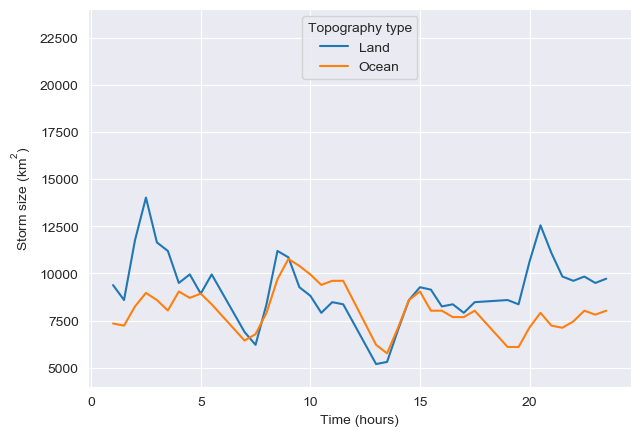

In [327]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
for i in range(len(filenames)):
    i=2
    print(filenames[i])

    time = list(np.arange(1,24,0.5))
    
    size_land = []
    size_land.extend([np.percentile(area, 53)*(4445*3334/256**2) for area in cloud_loggers_0_land[i]])
    size_land.extend([np.nan, np.nan])
    size_land.extend([np.percentile(area, 53)*(4445*3334/256**2) for area in cloud_loggers_6_land[i]])
    size_land.extend([np.nan, np.nan])
    size_land.extend([np.percentile(area, 53)*(4445*3334/256**2) for area in cloud_loggers_12_land[i]])
    size_land.extend([np.nan, np.nan])
    size_land.extend([np.percentile(area, 53)*(4445*3334/256**2) for area in cloud_loggers_18_land[i]])
    
    size_ocean = []
    size_ocean.extend([np.percentile(area, 53)*(4445*3334/256**2) for area in cloud_loggers_0_ocean[i]])
    size_ocean.extend([np.nan, np.nan])
    size_ocean.extend([np.percentile(area, 53)*(4445*3334/256**2) for area in cloud_loggers_6_ocean[i]])
    size_ocean.extend([np.nan, np.nan])
    size_ocean.extend([np.percentile(area, 52)*(4445*3334/256**2) for area in cloud_loggers_12_ocean[i]])
    size_ocean.extend([np.nan, np.nan])
    size_ocean.extend([np.percentile(area, 53)*(4445*3334/256**2) for area in cloud_loggers_18_ocean[i]])
    
    data_f = {
        'time': time,
        'area_land': size_land,
        'area_ocean': size_ocean
    }
    data_f = pd.DataFrame(data_f, columns=['time', 'area_land', 'area_ocean'])

    # %matplotlib inline
    plt.figure()
    plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
    sns.set_style('darkgrid')
    fig = sns.lineplot(x='time', y='value', hue='variable', data=pd.melt(data_f, ['time']))
    fig.set(xlabel='Time (hours)', ylabel='Storm size ($\mathregular{km^2}$)')
    plt.legend(title='Topography type', loc='upper center', labels=['Land', 'Ocean'])
    fig.set(ylim=(4000,24000))
    plt.show()
    break


Compare performace

In [ ]:
import time

t0= time.perf_counter()
for i in range(10000):
    image = cv2.imread(data_df.path[0])
t1 = time.perf_counter() - t0
print(t1)    


t0= time.perf_counter()
for i in range(10000):
    image = Image.open(data_df.path[0])
t1 = time.perf_counter() - t0
print(t1)

t0= time.perf_counter()
for i in range(10000):
    with open(var_dir + 'image_file', 'rb') as f:
        image = pickle.load(f)
t1 = time.perf_counter() - t0
print(t1)

255 Error fix

In [ ]:
filenames = glob.glob(data_dir + '*')

data_dir = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Data/'
data_dir_2 = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Data/'

for i in tqdm(range(len(filenames))):
    
    fn = filenames[i]
    nc_id = os.path.splitext(os.path.basename(fn))[0]
    
    # Open
    with open(fn, 'rb') as f: 
        data = pickle.load(f)
    
    # Change values    
    data[:,:,0] = normalize(data[:,:,0], 0, 255)
    data[:,:,1] = normalize(data[:,:,1], 0, 255)
    
    # Save
    with open(data_dir_2 + nc_id, 'wb') as f:
        pickle.dump(data, f)
        


Float 32/64 FIX

In [15]:
data_dir = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Data/'
data_dir_2 = 'C:/Users/marcv/OneDrive/Documentos/Python Scripts/Dissertation/Data_float32/'
filenames = glob.glob(data_dir + '*')

for i in tqdm(range(len(filenames))):
    
    fn = filenames[i]
    nc_id = os.path.splitext(os.path.basename(fn))[0]
    
    # Skip if already converted to data
    if os.path.isfile(data_dir_2 + nc_id):
        continue
        
    # Open
    with open(fn, 'rb') as f: 
        data = pickle.load(f)
    
    # Change values    
#     if type(data[0,0,0]) is np.float32 or type(data[0,0,1]) is np.float32 or type(data[0,0,2]) is np.float32 or type(data[0,0,3]) is np.float32:
#         data = np.float64(data)
        
    if type(data[0,0,0]) is np.float64 or type(data[0,0,1]) is np.float64 or type(data[0,0,2]) is np.float64 or type(data[0,0,3]) is np.float64:
        data = np.float32(data)    
        
        # Save
        with open(data_dir_2 + nc_id, 'wb') as f:
            pickle.dump(data, f)



Show changes in learning rate

In [ ]:
with open(var_dir + 'losses_ConvLSTM_ReLu_6cur__2to2__ep9', 'rb') as f:
    losses = pickle.load(f)
num_epochs = 9    

lr_change = []
best = 100000000
count = 0
for loss in losses[1]:
    if loss < best:
        best = loss
        lr_change.append(0)
        count = 0
    else:
        count = count + 1
        if count < 6:
            lr_change.append(0)
        else:
            best = loss
            print(loss)
            lr_change.append(4000)
            count = 0

while losses[1][0] > losses[0][0]*2:
        losses[1][0] = losses[1][0]/2
x1 = np.linspace(0, num_epochs, len(losses[0]))
x2 = np.linspace(0, num_epochs, len(losses[1]))
x3 = np.linspace(0, num_epochs, len(lr_change))
plt.plot(x1, losses[0], label="Training Loss")
plt.plot(x2, losses[1], label="Validation Loss")
plt.plot(x3, lr_change, label="Learning rate change")
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.show()

Problem from old evaluators

In [ ]:
import cmath

# evaluators = openVariable(model_dir, 'evaluators_TARGET')
# evaluators = openVariable(model_dir, 'evaluators_CNN_ReLu_#1__2to1__3075')
# evaluators = openVariable(model_dir, 'evaluators_ConvLSTM_ReLu_#1__2to1__loss9886')
evaluators = openVariable(model_dir, 'evaluators_ConvLSTM_ReLu_6cur_#4__2to1__9688')

tmp_1 = []
tmp_2 = []

for ev in evaluators:
    _, tmp_dA_upp, _, _ = ev.MovingDistance(0)
#     _, _, tmp_dA_upp, _ = ev.MovingDistance(0)
#     _, _, _, tmp_dA_upp = ev.MovingDistance(0)
    
    tmp_dA_upp = np.sum(tmp_dA_upp, axis=0) / len(tmp_dA_upp)
    tmp_dA_upp = complex(tmp_dA_upp[0], tmp_dA_upp[1])

    tmp_1.append(abs(tmp_dA_upp))
    tmp_2.append(math.degrees(cmath.phase(tmp_dA_upp)))
    
table = [list(range(1, len(evaluators) + 1)), 
         tmp_1, tmp_2]
print(tabulate(table))